In [12]:
#Useful Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chart_studio.plotly
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.offline import iplot

pyo.init_notebook_mode()
pd.set_option('display.max_columns', 500)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [13]:
#Loading the raw data
raw_data=pd.read_csv('results.csv')
raw_data.sample(5)

date    home_team away_team  home_score  away_score  \
19384  1996-02-04      Bolivia     Chile           1           1   
34838  2013-01-14  Ivory Coast     Egypt           4           2   
24924  2002-08-20      Algeria  DR Congo           1           1   
14006  1986-01-22        Gabon   Senegal           0           1   
21970  1999-05-30       Norway   Georgia           1           0   

                    tournament        city               country  neutral  
19384                 Friendly  Cochabamba               Bolivia    False  
34838                 Friendly   Abu Dhabi  United Arab Emirates     True  
24924                 Friendly       Blida               Algeria    False  
14006                 Friendly  Libreville                 Gabon    False  
21970  UEFA Euro qualification        Oslo                Norway    False

# Preprocessing

The dataset at hand is pretty straight-forward, seems to have no missing data nor corrupted information. That being said, some irrelevant information can be observed:

In [14]:
raw_data[raw_data['home_team']=='Provence'].head()

date home_team        away_team  home_score  away_score  \
30447  2008-07-08  Provence          Padania           1           6   
30448  2008-07-09  Provence  Iraqi Kurdistan           0           3   
31359  2009-06-22  Provence             Gozo           3           1   
31368  2009-06-25  Provence  Iraqi Kurdistan           0           6   
31371  2009-06-26  Provence            Sápmi           4           4   

           tournament        city country  neutral  
30447  Viva World Cup   Gällivare  Sweden     True  
30448  Viva World Cup  Malmberget  Sweden     True  
31359  Viva World Cup      Novara   Italy     True  
31368  Viva World Cup      Varese   Italy     True  
31371  Viva World Cup     Brescia   Italy     True

Teams from cities and regions can be observed, so the international matches featured in the dataset do not strickly include national teams rather any team that participated to an international match at some point. We now then need to get rid of them.

In [15]:
#Removing all teams not recognised by the FIFA (non-national and unofficial teams)
official_teams=raw_data[raw_data['tournament']=='FIFA World Cup qualification']
official_teams=pd.concat([official_teams['home_team'],official_teams['away_team']]).unique()
team_filter=raw_data['home_team'].isin(official_teams) & raw_data['away_team'].isin(official_teams)
removed_teams=pd.concat([raw_data[~raw_data['home_team'].isin(official_teams)]['home_team'],raw_data[~raw_data['away_team'].isin(official_teams)]['away_team']]).unique()
data=raw_data[team_filter]
#Printing the name of all removed teams
print('Removed teams:',removed_teams)

Removed teams: ['Catalonia' 'Basque Country' 'Brittany' 'Galicia' 'Andalusia'
 'Central Spain' 'Silesia' 'Guadeloupe' 'French Guiana' 'Manchukuo'
 'Martinique' 'Réunion' 'Zanzibar' 'Kernow' 'North Vietnam'
 'Northern Cyprus' 'Kiribati' 'Wallis Islands and Futuna' 'Greenland'
 'Niue' 'Palau' 'Sint Maarten' 'Åland Islands' 'Ynys Môn' 'Saint Martin'
 'Jersey' 'Shetland' 'Isle of Wight' 'Guernsey' 'Isle of Man'
 'Canary Islands' 'Frøya' 'Hitra' 'Corsica' 'Gotland' 'Saare County'
 'Rhodes' 'Micronesia' 'Orkney' 'Monaco' 'Tuvalu' 'Sark' 'Alderney'
 'Mayotte' 'Western Isles' 'Falkland Islands' 'Republic of St. Pauli'
 'Găgăuzia' 'Tibet' 'Crimea' 'Occitania' 'Sápmi'
 'Northern Mariana Islands' 'Menorca' 'Provence' 'Arameans Suryoye'
 'Padania' 'Iraqi Kurdistan' 'Gozo' 'Bonaire' 'Western Sahara' 'Raetia'
 'Darfur' 'Tamil Eelam' 'Abkhazia' 'Saint Pierre and Miquelon' 'Artsakh'
 'Madrid' 'Vatican City' 'Ellan Vannin' 'South Ossetia' 'County of Nice'
 'Székely Land' 'Romani people' 'Felvidék' 'Cha

# Exploratory Analysis

### DataTypes and general informations about the dataset

In [16]:
data.shape

(39654, 9)

In [17]:
pd.DataFrame(data.dtypes).T

date home_team away_team home_score away_score tournament    city  \
0  object    object    object      int64      int64     object  object   

  country neutral  
0  object    bool

____
## Number of matches
### Distribution of the number of matches  by decade

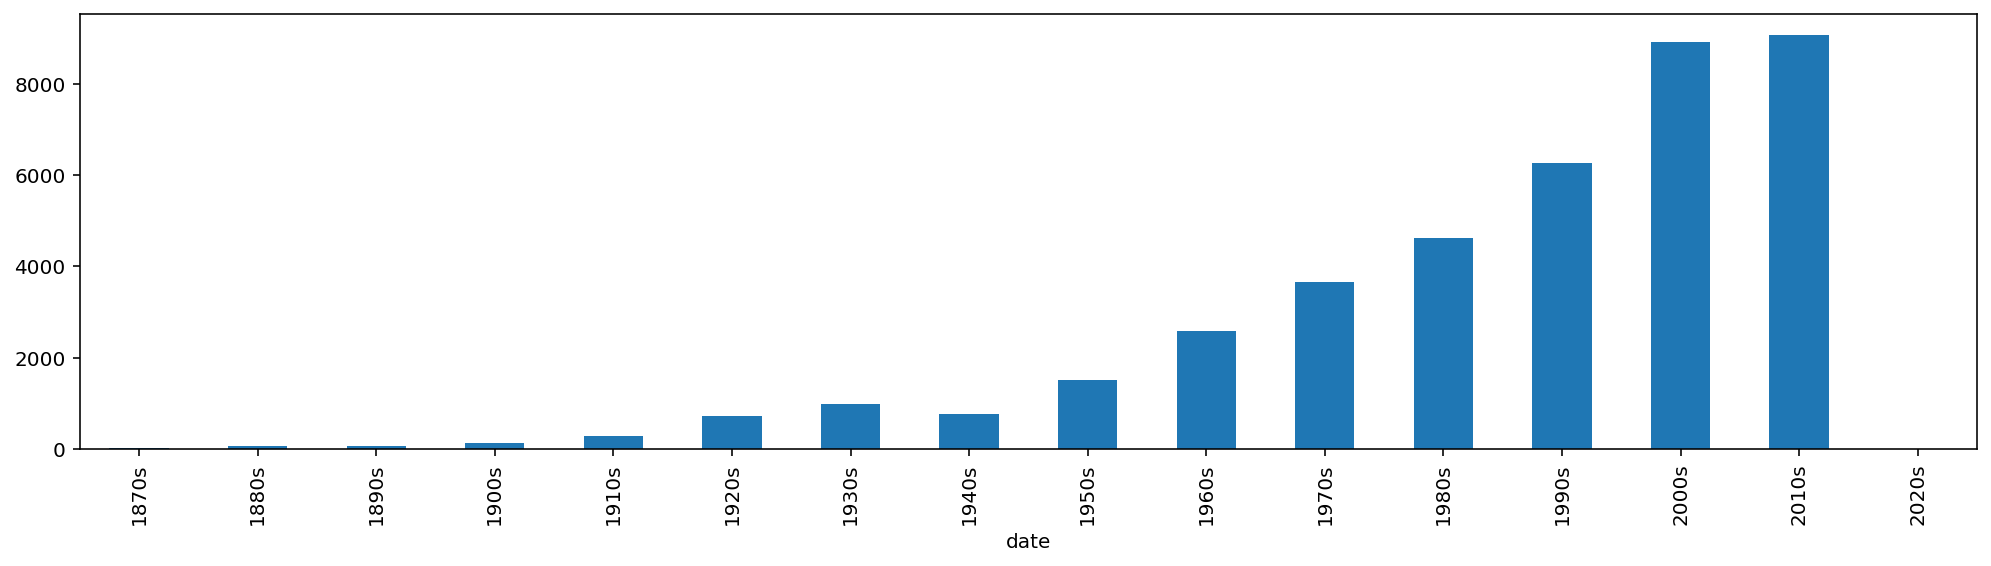

In [18]:
decades=data['date'].str.slice(0,3)
decades=decades.astype(str)+'0s'
decades=decades.groupby(decades).count()
pd.DataFrame(decades).plot.bar(y=0,legend=False, figsize=(17,4))
plt.show()  

We notice that the amount of international matches per year increased exponentially over time.

### Distribution of the number matches per team (full distribution, top and low 50)

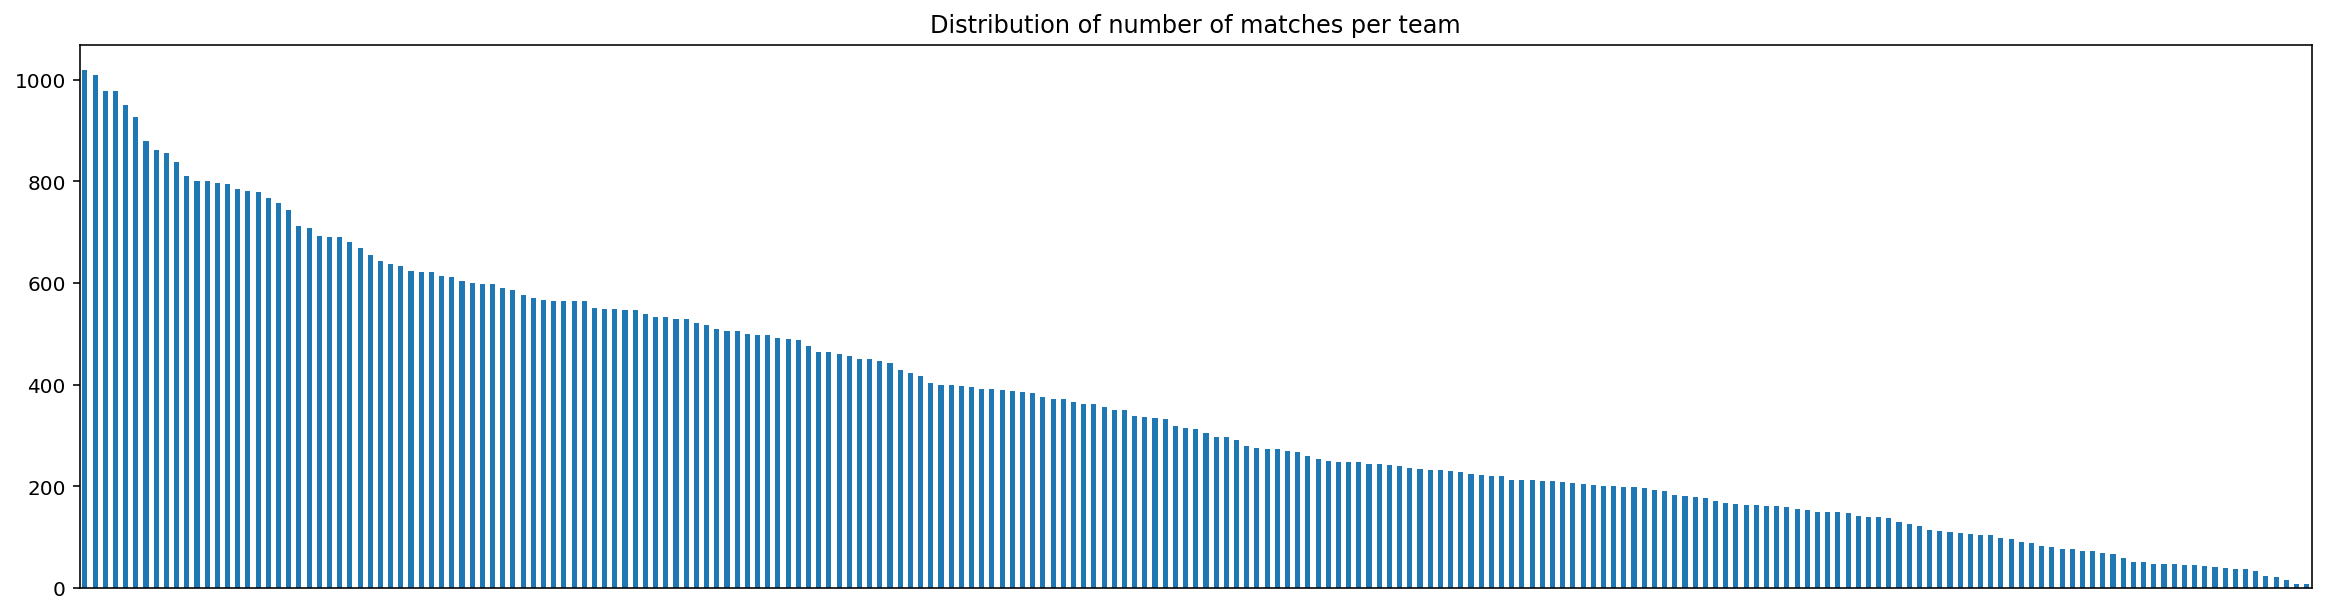

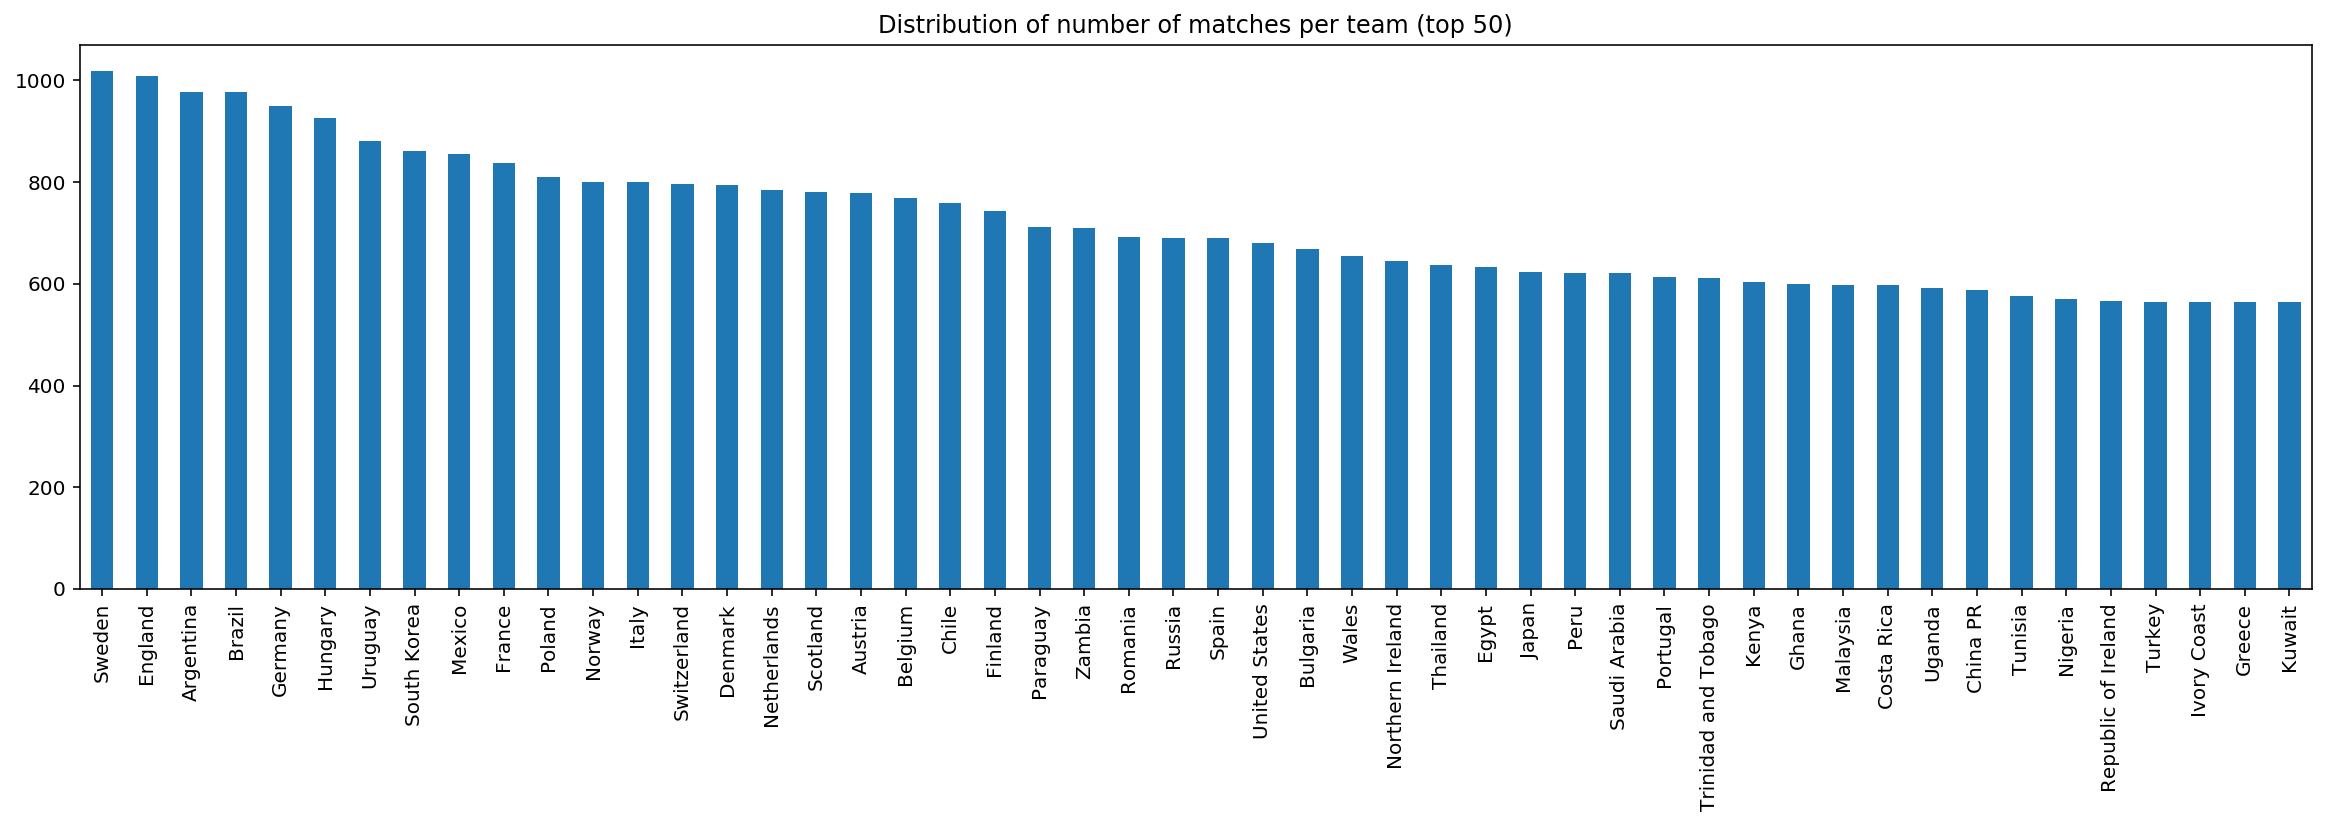

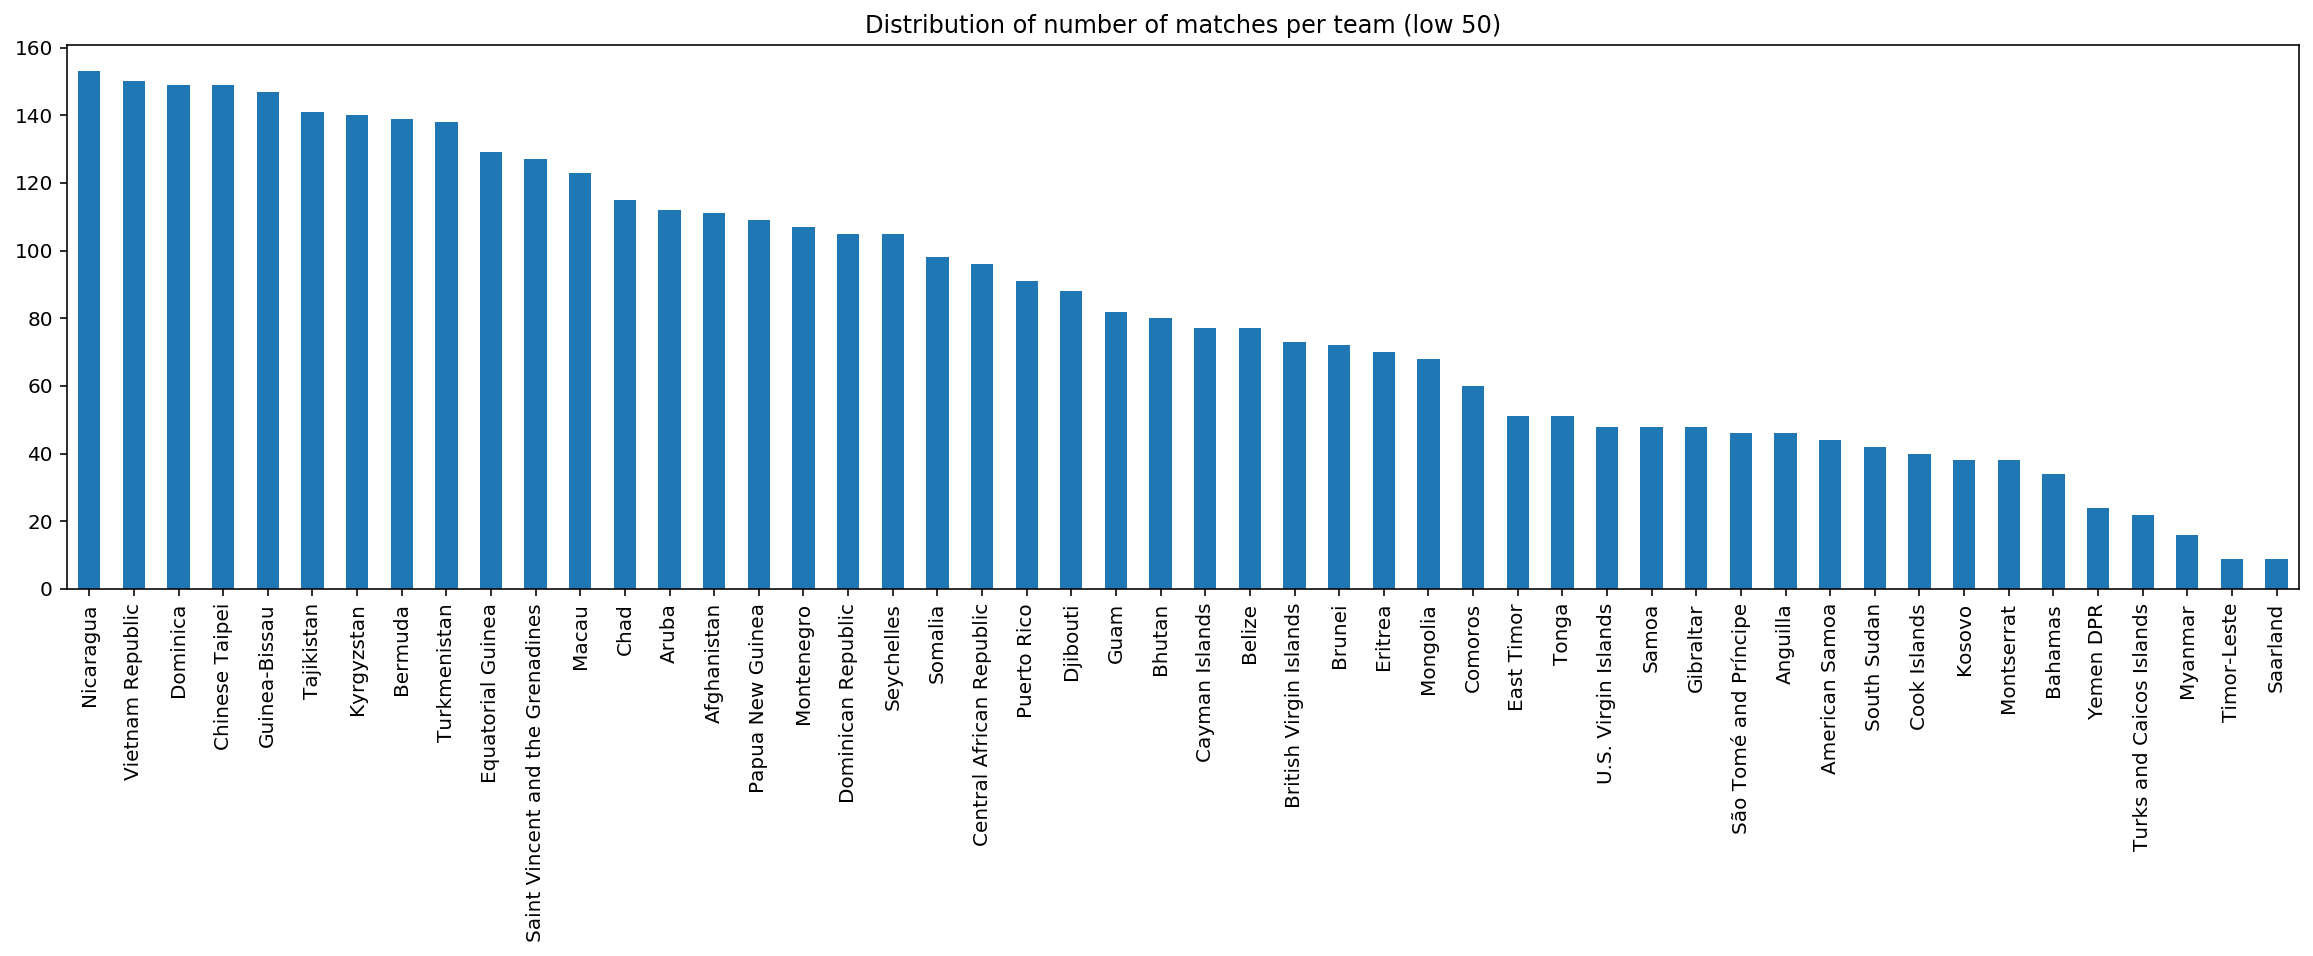

In [19]:
match_participants=pd.concat([data['home_team'],data['away_team']])
match_participants=match_participants.groupby(match_participants).count().sort_values(0, ascending=False)
pd.DataFrame(match_participants[:]).plot.bar(y=0,legend=False, figsize=(20,5),
                                                title='Distribution of number of matches per team')
f = plt.gca()
f.axes.get_xaxis().set_visible(False)
pd.DataFrame(match_participants[:50]).plot.bar(y=0,legend=False, figsize=(20,5),
                                               title='Distribution of number of matches per team (top 50)')
pd.DataFrame(match_participants[-50:]).plot.bar(y=0,legend=False, figsize=(20,5),
                                                title='Distribution of number of matches per team (low 50)')

plt.show()

In [20]:
pd.DataFrame(match_participants.describe()).T

count        mean         std  min    25%    50%    75%     max
0  219.0  362.136986  245.589012  9.0  163.5  312.0  542.0  1018.0

We can observe a sharpe difference in the number of matches between the top 50 and low 50 teams. This explains the large standard deviation. In addition, we note that the teams playing the least are often teams from smaller countries.


### Distribution of away matches per team (top and low 50)

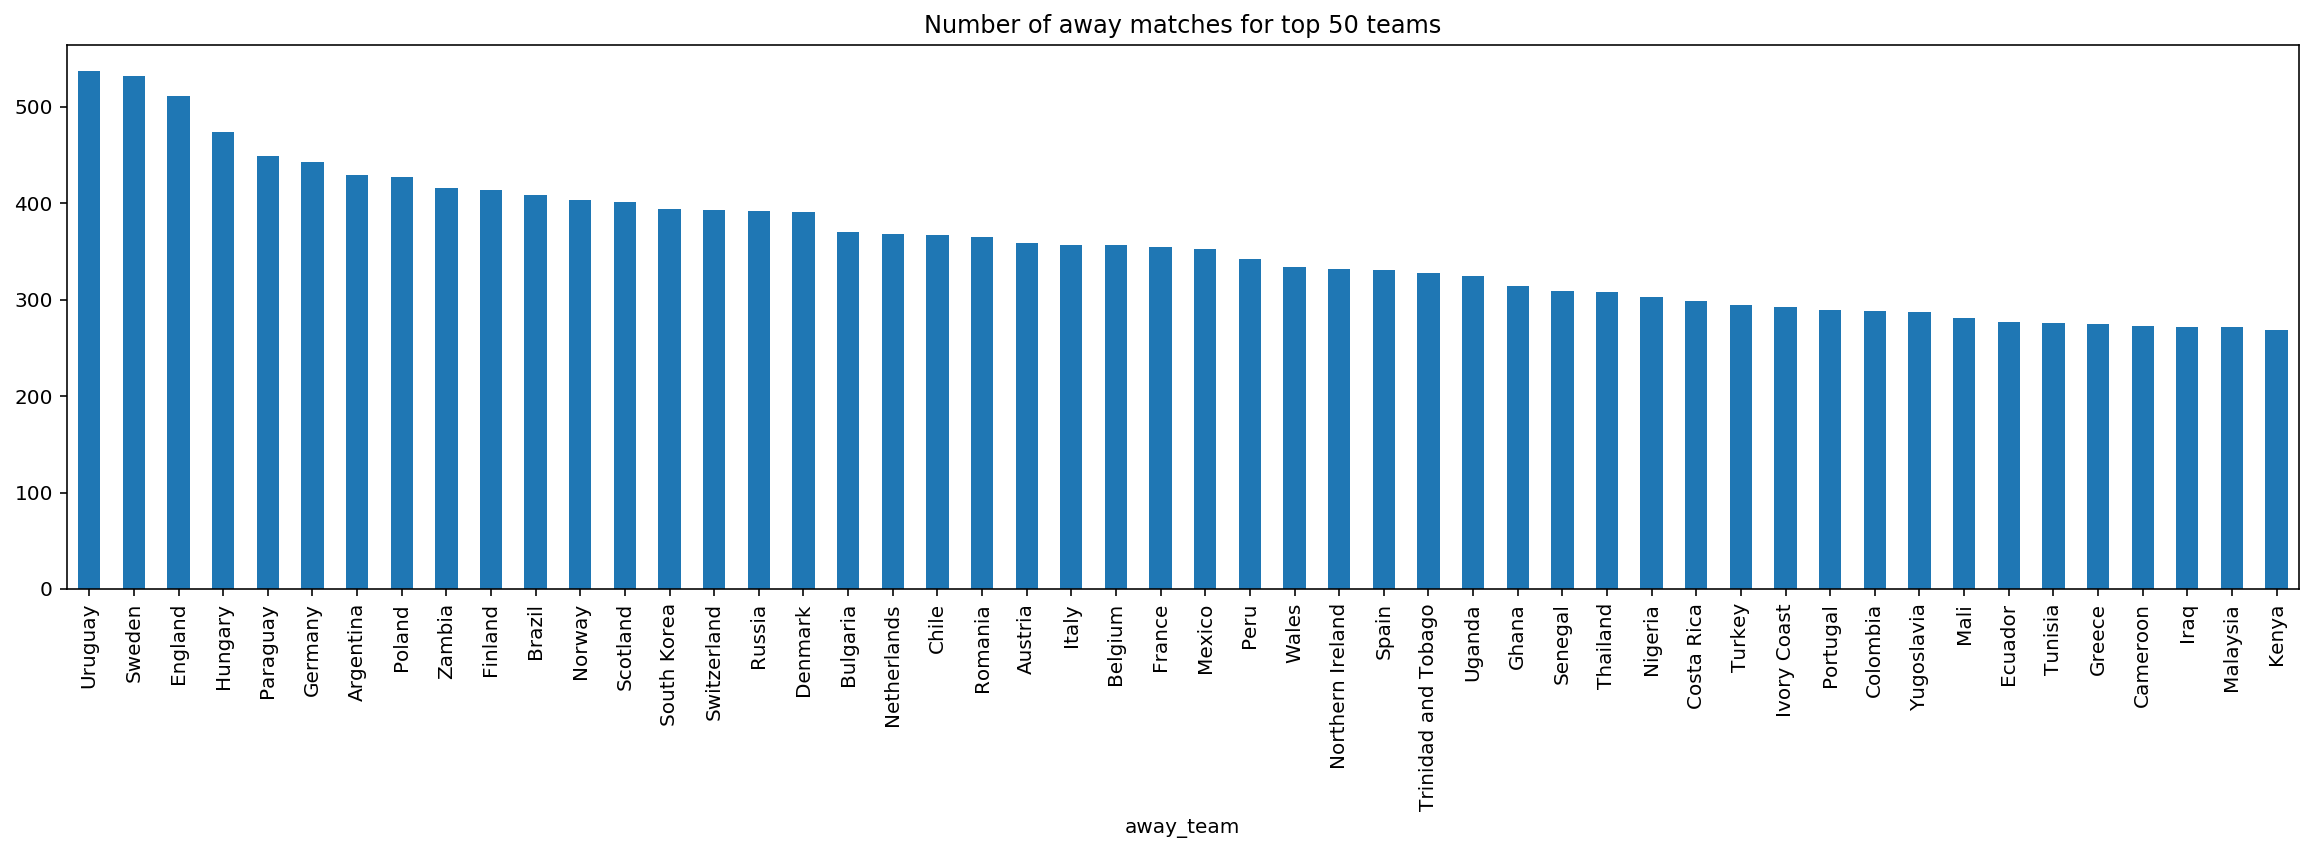

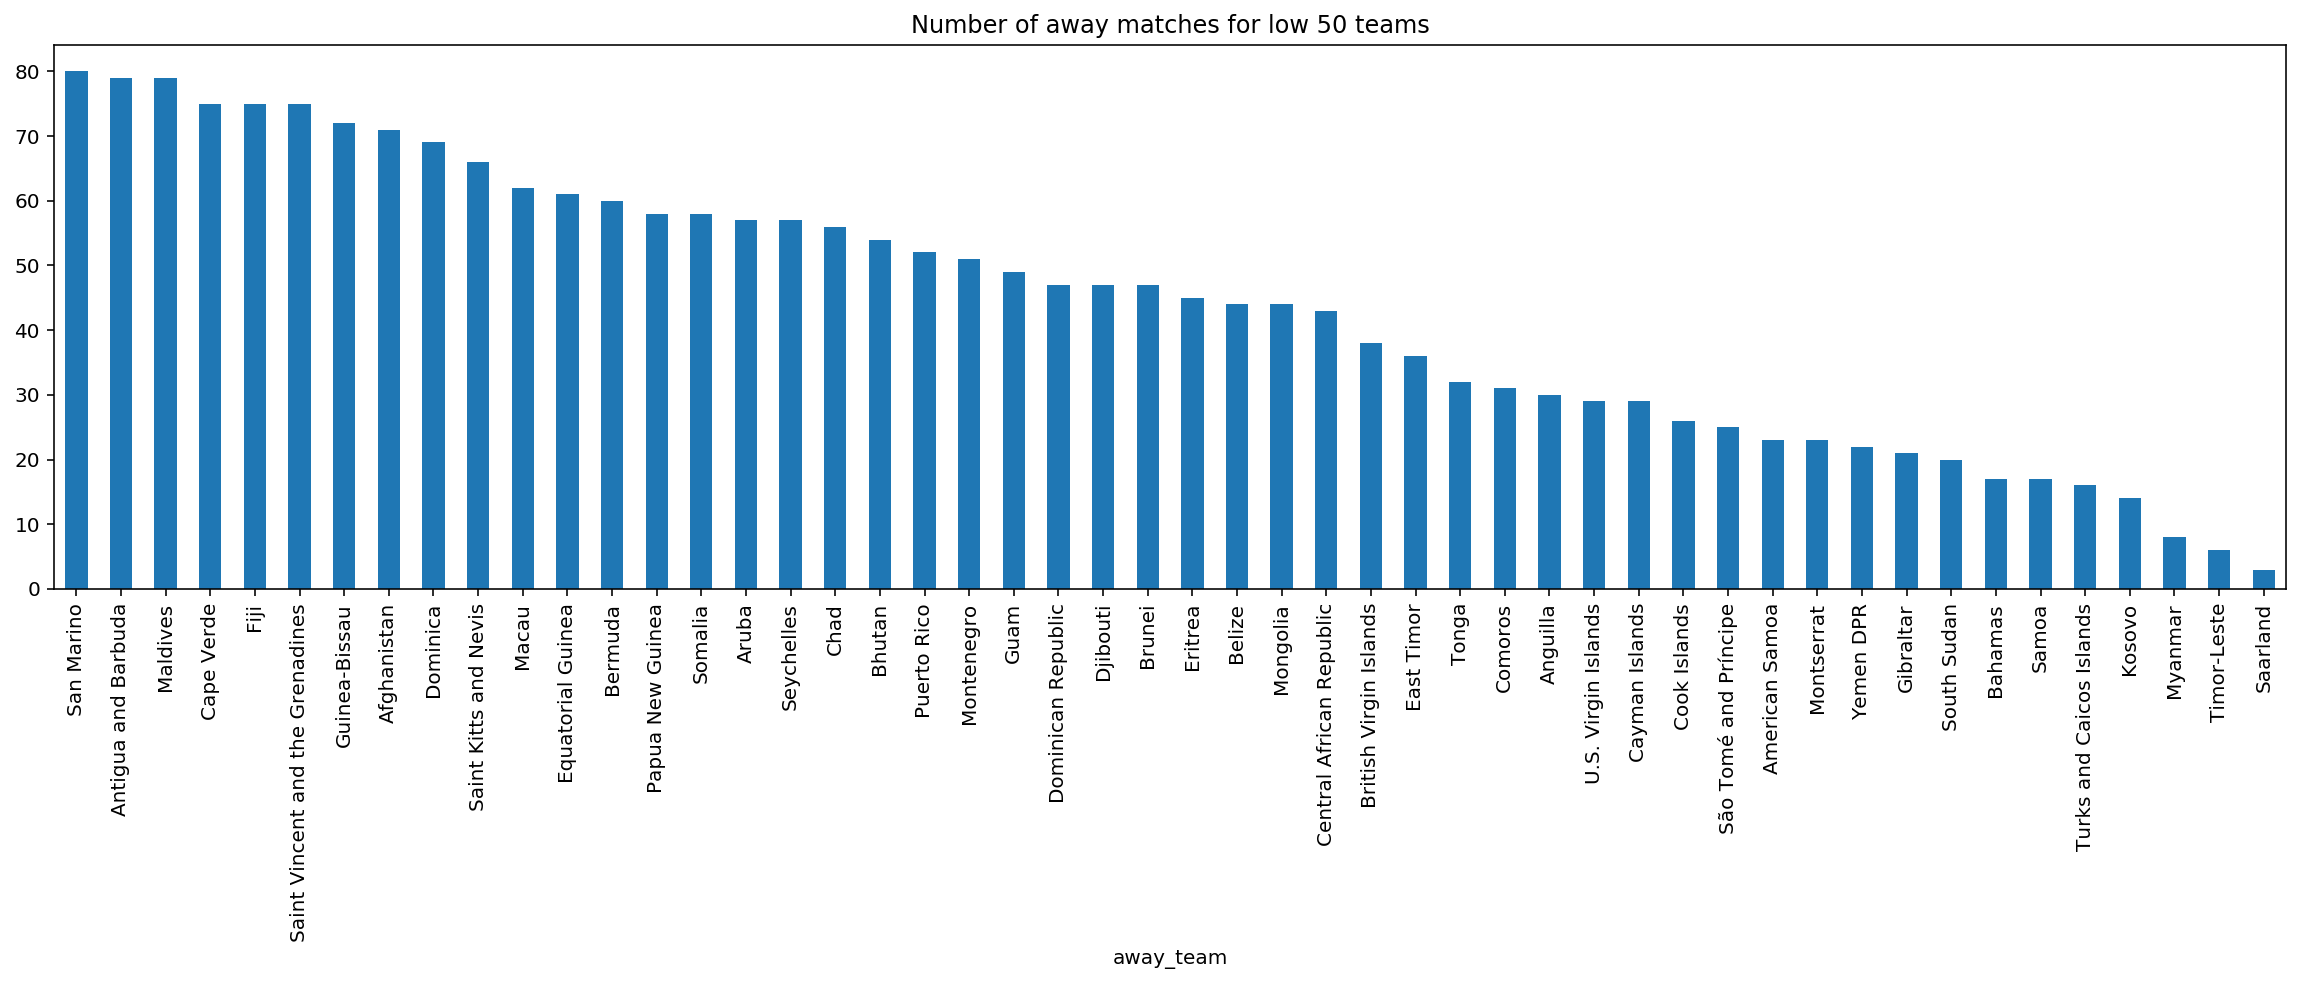

In [21]:
away_participants=data['away_team'].groupby(data['away_team']).count().sort_values(0, ascending=False)
pd.DataFrame(away_participants[:50]).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Number of away matches for top 50 teams')
pd.DataFrame(away_participants[-50:]).plot.bar(y=0,legend=False, figsize=(20,5),
                                               title='Number of away matches for low 50 teams')
plt.show()

### Distribution of home matches per country (top and low 50)


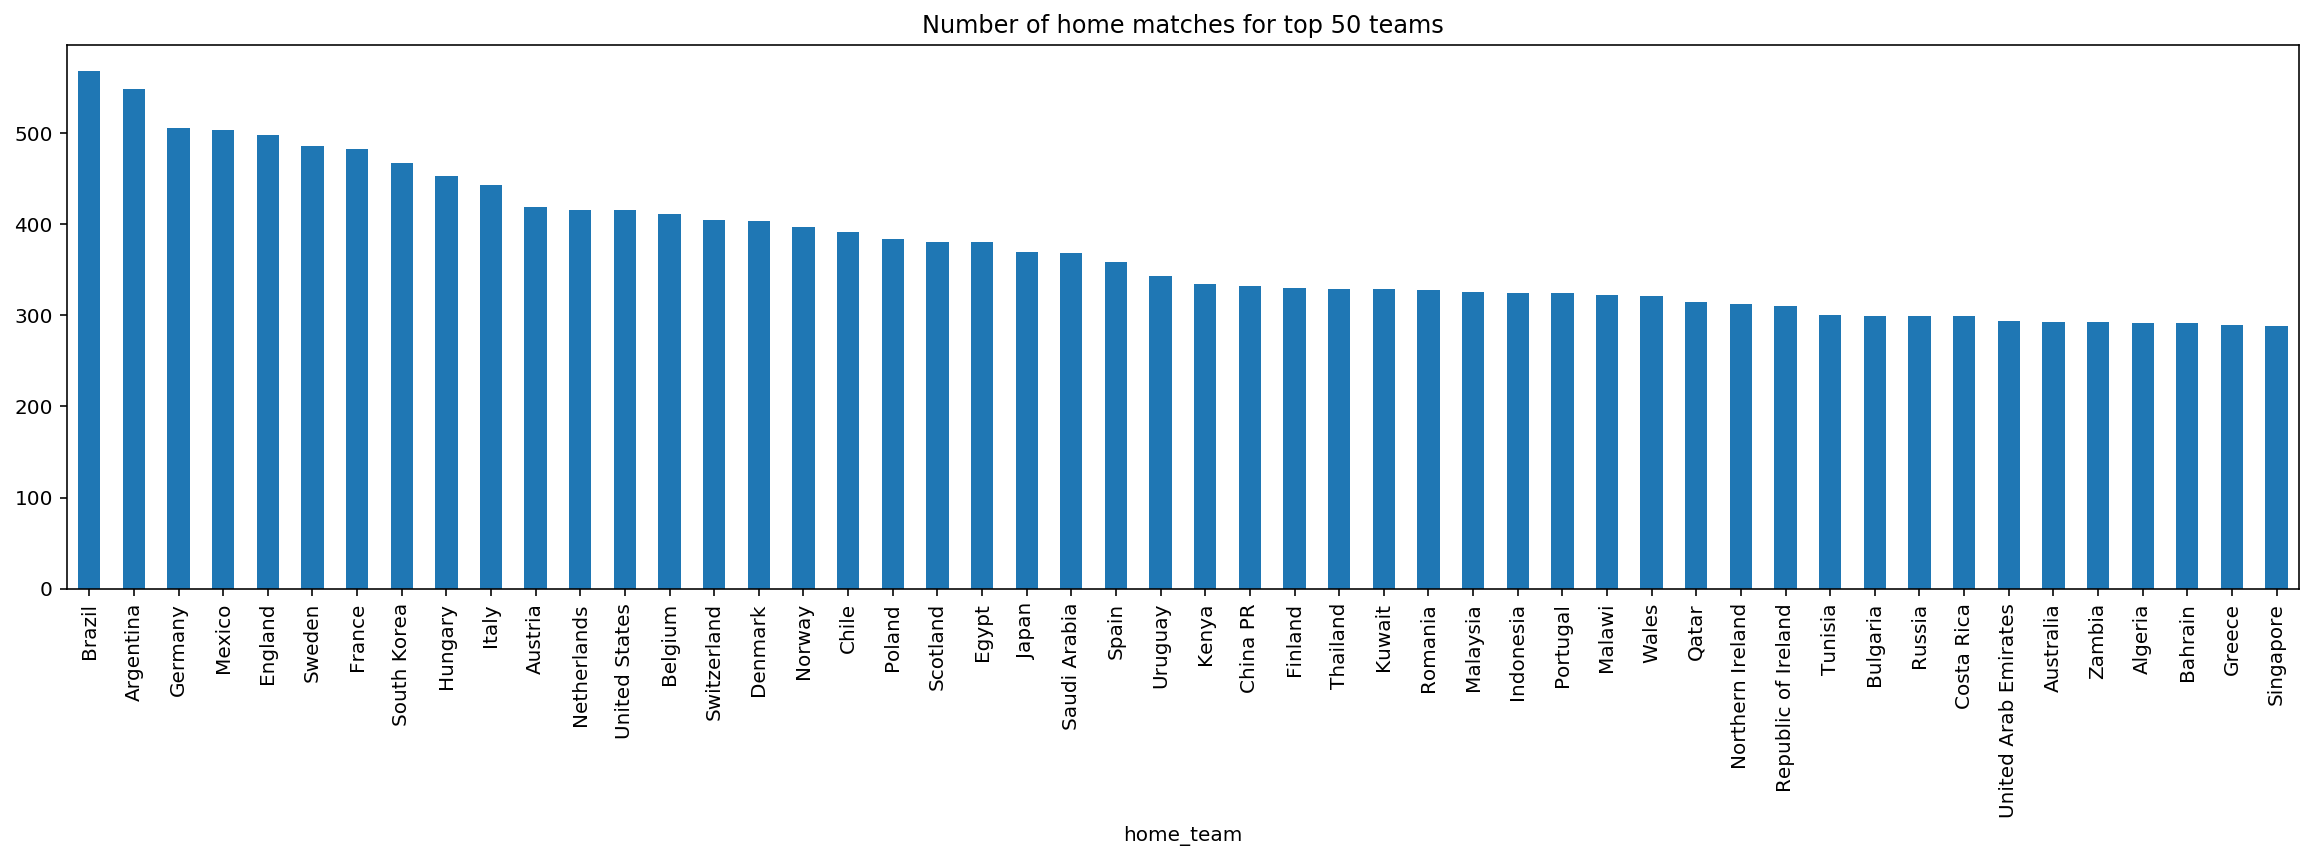

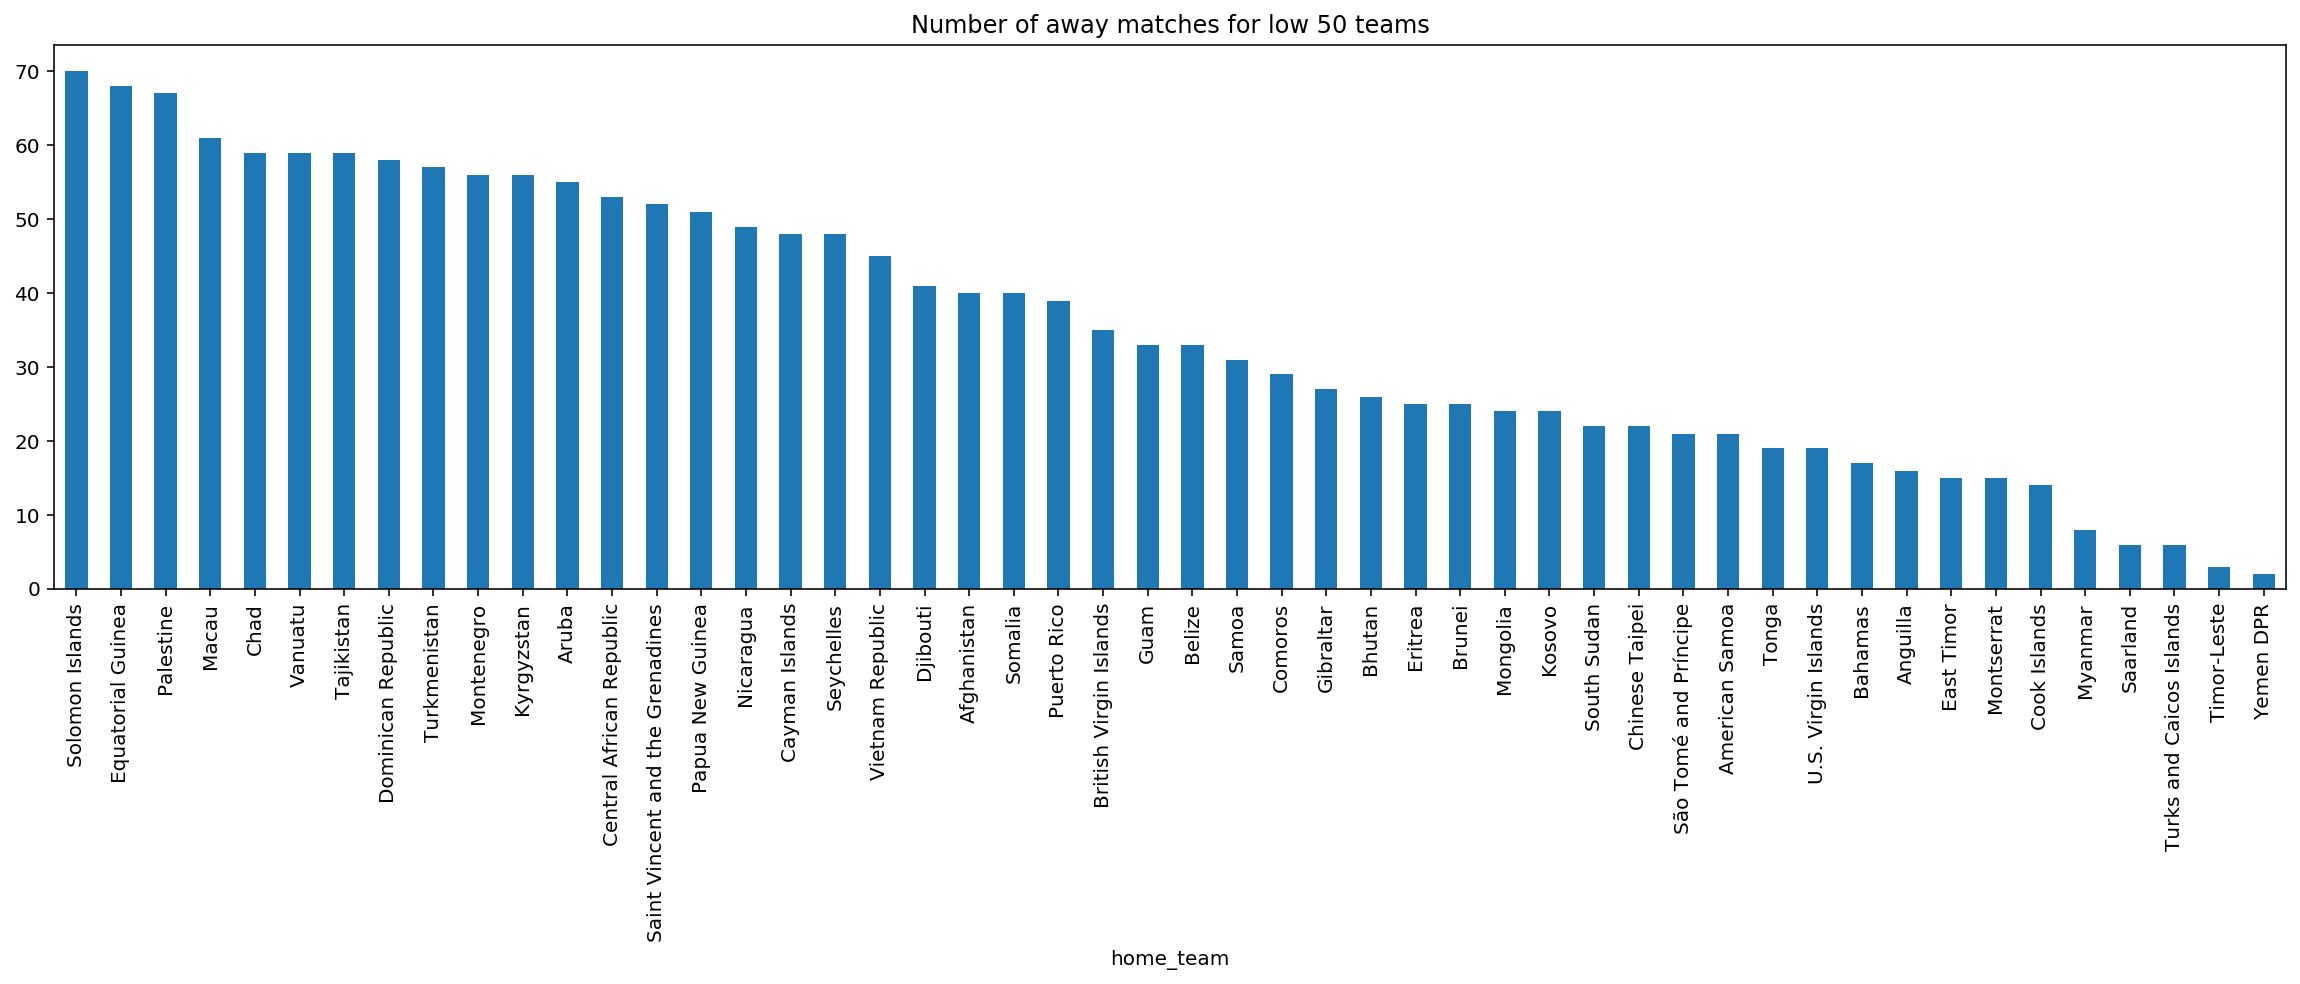

In [22]:
home_participants=data['home_team'].groupby(data['home_team']).count().sort_values(0, ascending=False)
pd.DataFrame(home_participants[:50]).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Number of home matches for top 50 teams')

pd.DataFrame(home_participants[-50:]).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Number of away matches for low 50 teams')
plt.show()

## Scores
### Distribution of goals scored by individual teams per match

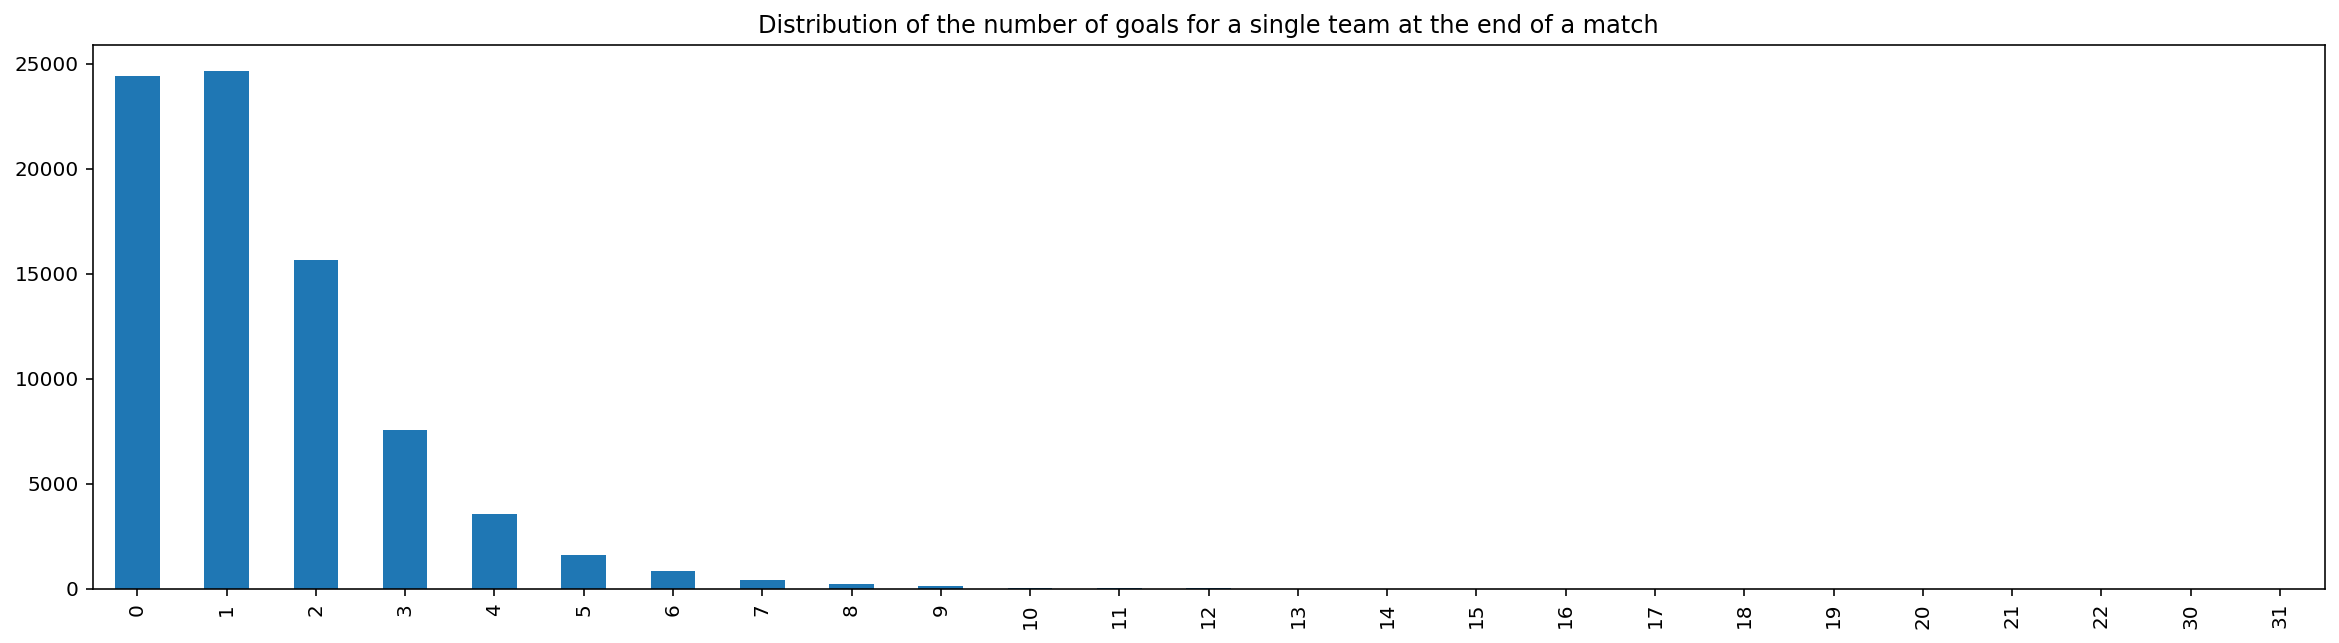

In [23]:
final_scores=pd.concat([data['home_score'],data['away_score']])
final_score_count=final_scores.groupby(final_scores).count()
pd.DataFrame(final_score_count).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Distribution of the number of goals for a single team at the end of a match')
plt.show()

### Teams score general stats

In [24]:
pd.DataFrame(final_scores.describe()).T

count      mean       std  min  25%  50%  75%   max
0  79308.0  1.445226  1.567368  0.0  0.0  1.0  2.0  31.0

### Distribution of goals scored by home teams per match

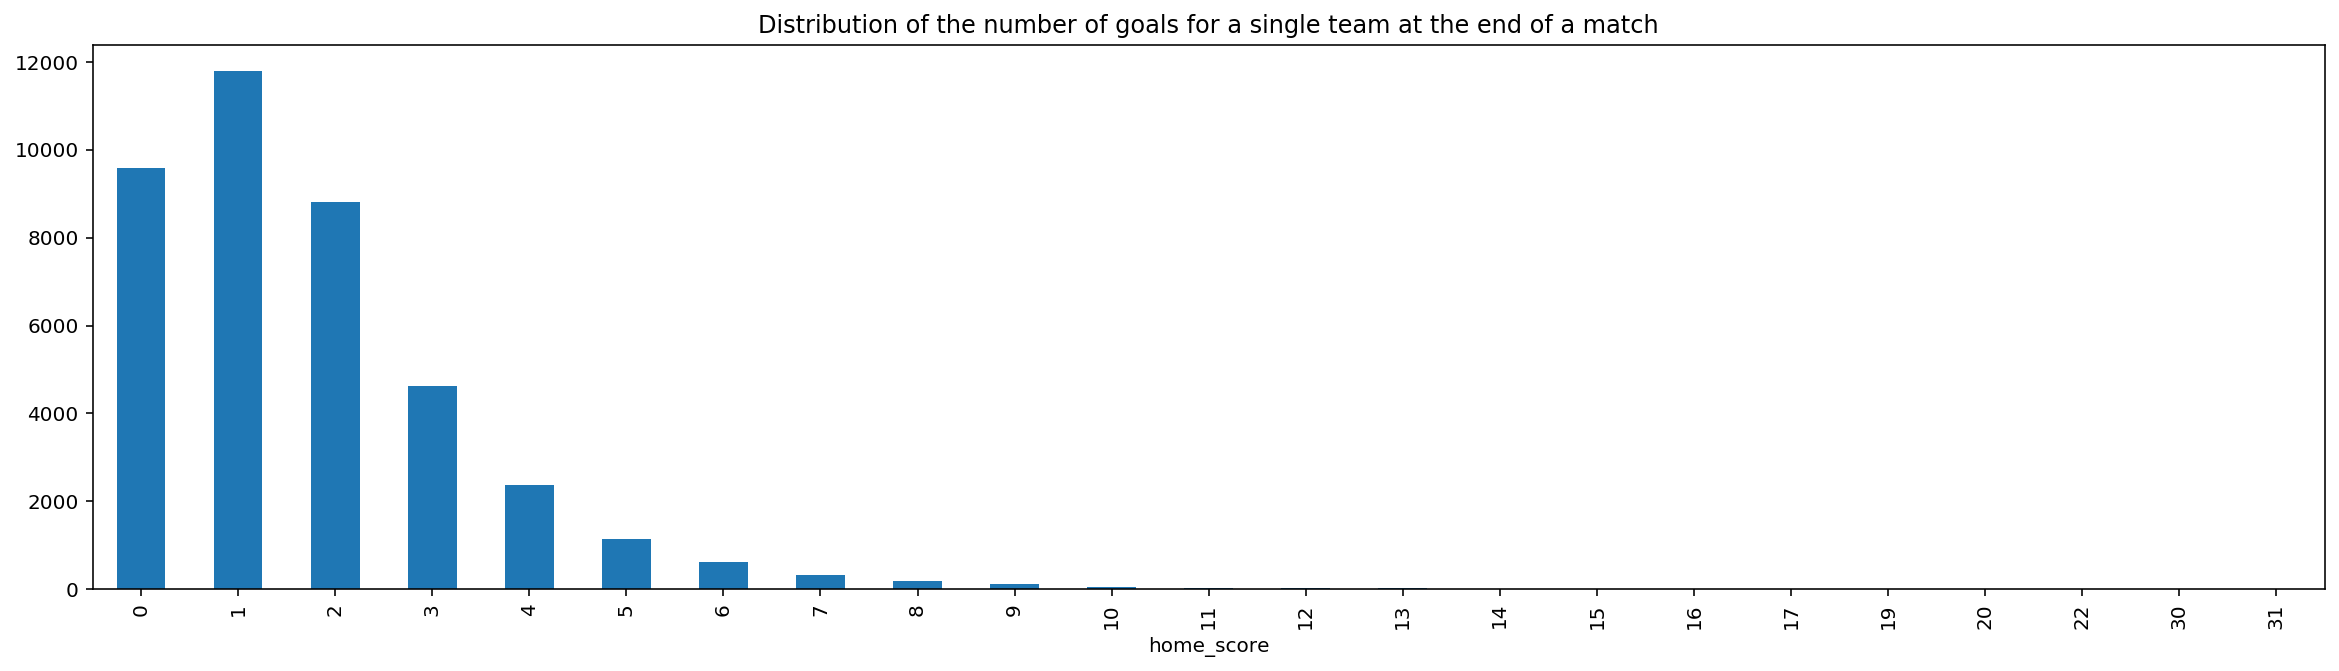

In [25]:
home_final_score_count=data['home_score'].groupby(data['home_score']).count()
pd.DataFrame(home_final_score_count).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Distribution of the number of goals for a single team at the end of a match')
plt.show()

We seem to have an Erlang distribution.

### Distribution of goals scored by away teams per match

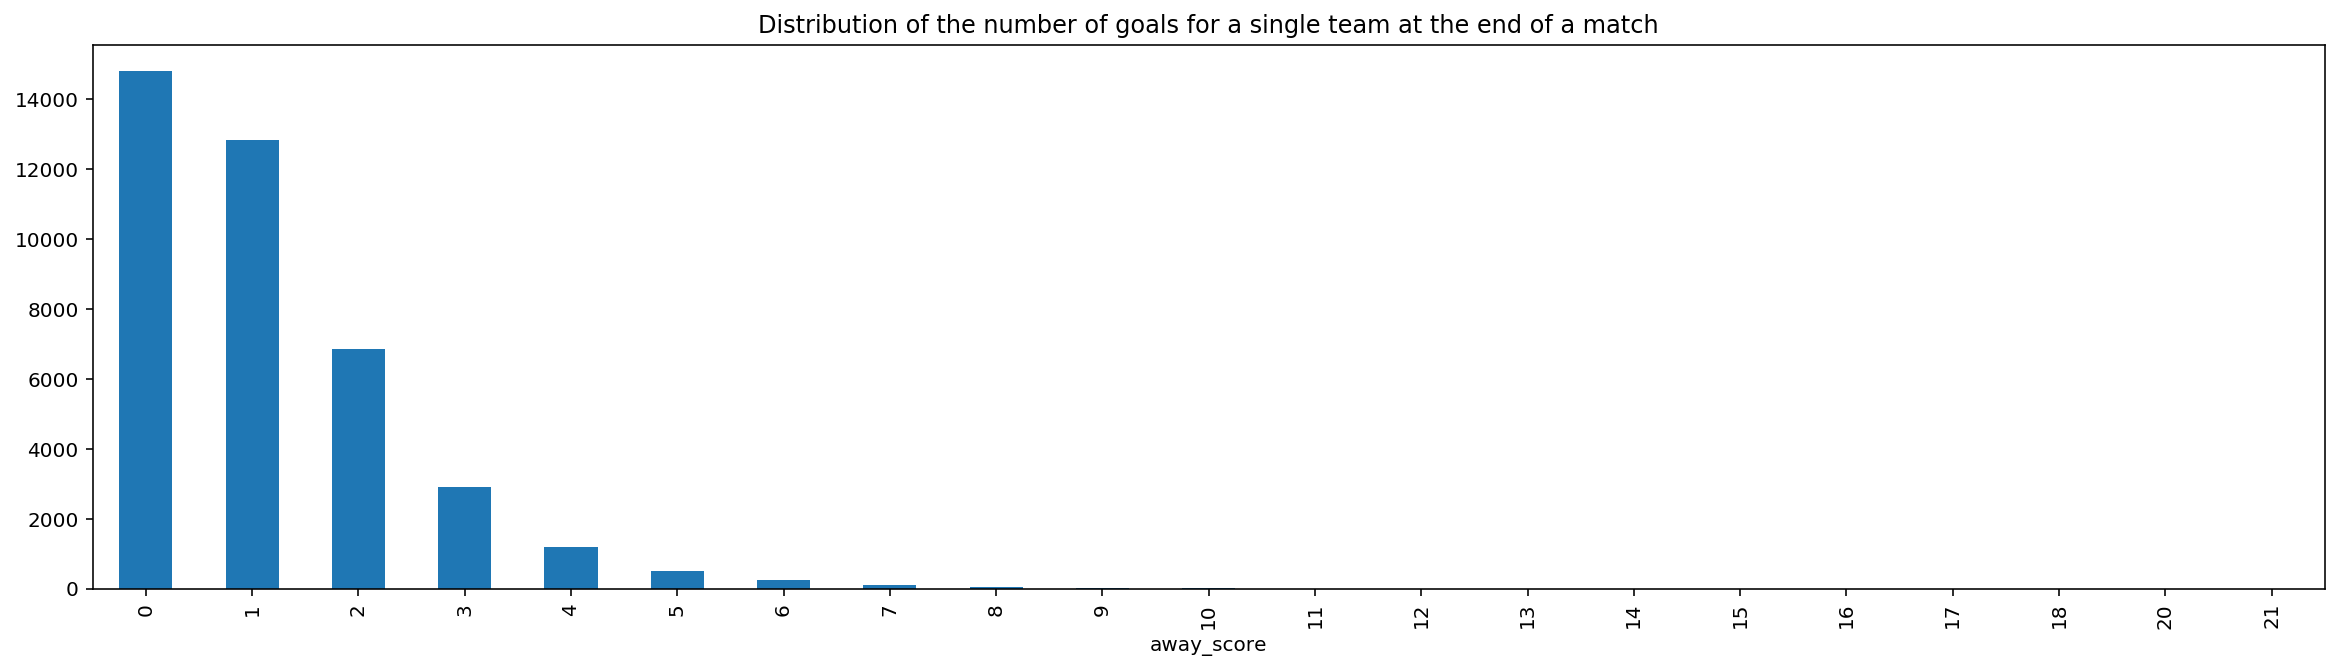

In [26]:
away_final_score_count=data['away_score'].groupby(data['away_score']).count()
pd.DataFrame(away_final_score_count).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Distribution of the number of goals for a single team at the end of a match')
plt.show()

Here, the likelihood of each score seems to decrease exponentially with the number of goals. 

### Total Score

Let's now look at the total number of goals per game (away + home score):

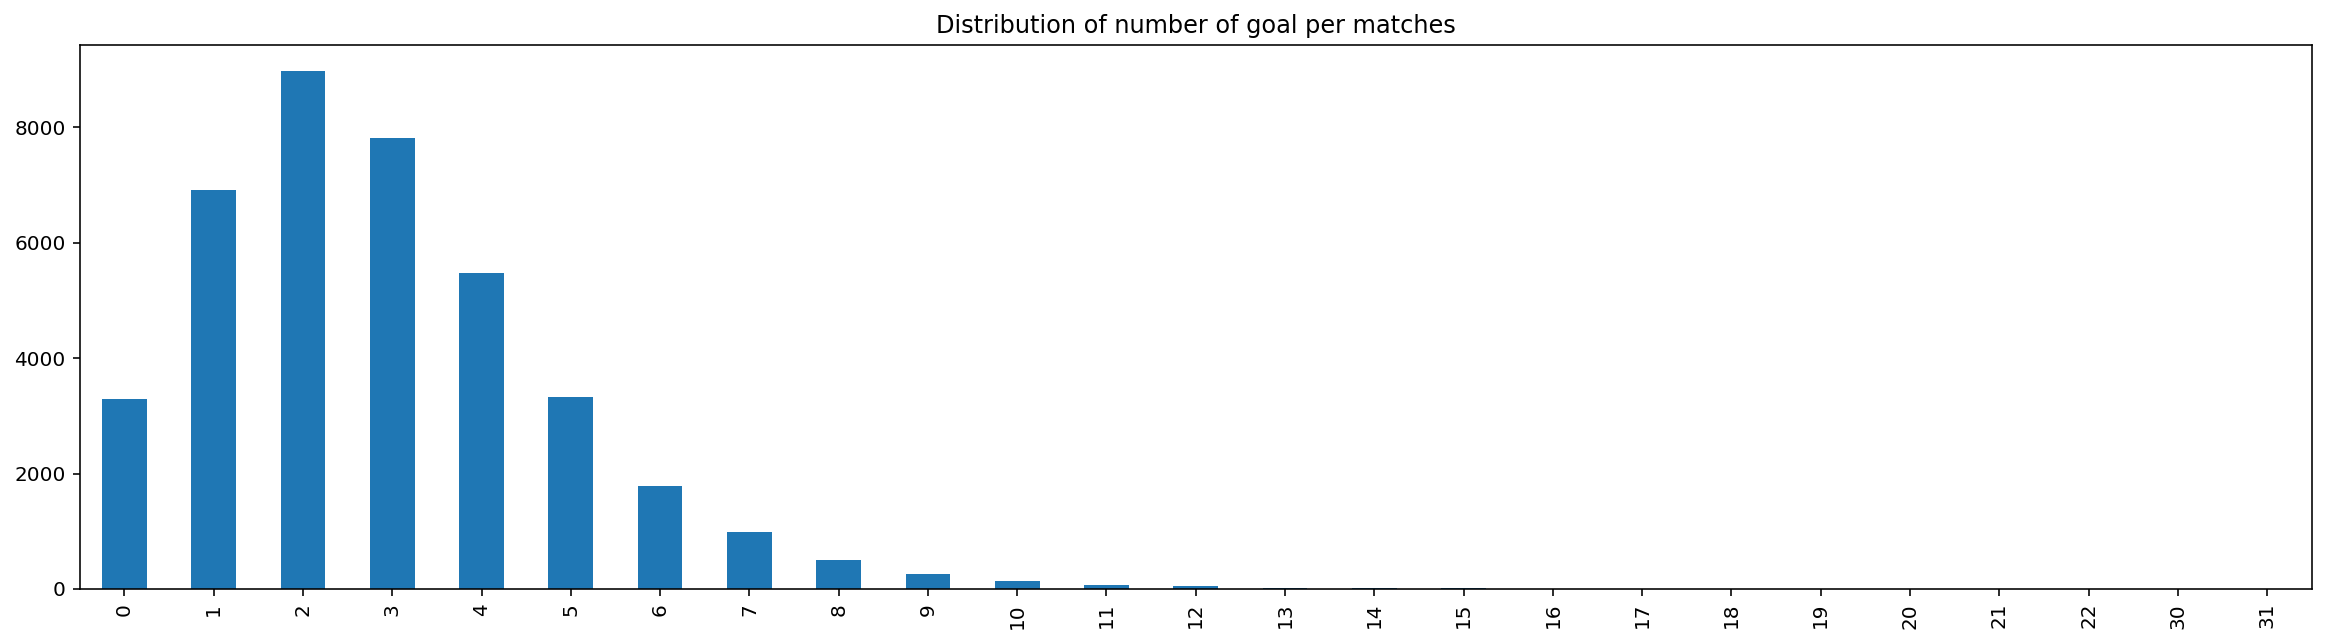

In [27]:
total_scores = data['home_score'] + data['away_score']
total_scores_count=total_scores.groupby(total_scores).count()
pd.DataFrame(total_scores_count).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Distribution of number of goal per matches')
plt.show()

The total number of goals scored per match seems to follow an Erlang distribution.To get the corresponding random viariable, we've summed-up an exponentially distributed variable with an Erlang distributed one. This might mean the two variables are independent.

### Total score general stats

In [28]:
pd.DataFrame(total_scores.describe()).T

count      mean       std  min  25%  50%  75%   max
0  39654.0  2.890452  2.036908  0.0  1.0  3.0  4.0  31.0

## Types of matches

### Repartition of friendly vs competitive matches

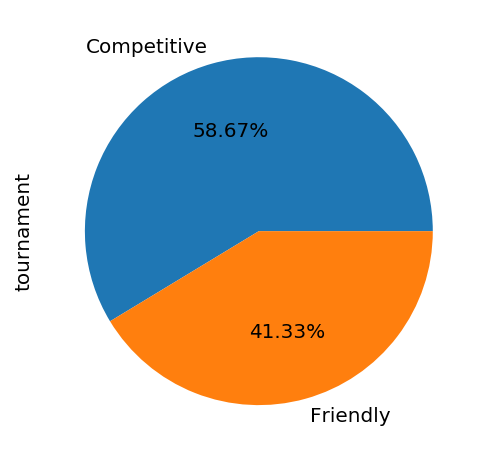

In [29]:
f_vs_c=data['tournament'].copy()
f_vs_c[f_vs_c!='Friendly']='Competitive'
pd.DataFrame(f_vs_c).groupby(f_vs_c).count().plot.pie(y=0, autopct='%1.2f%%', startangle=0, legend=False)
plt.show()

A surpringly large amount of matches are friendly.

## Distribution of the matches per tournament

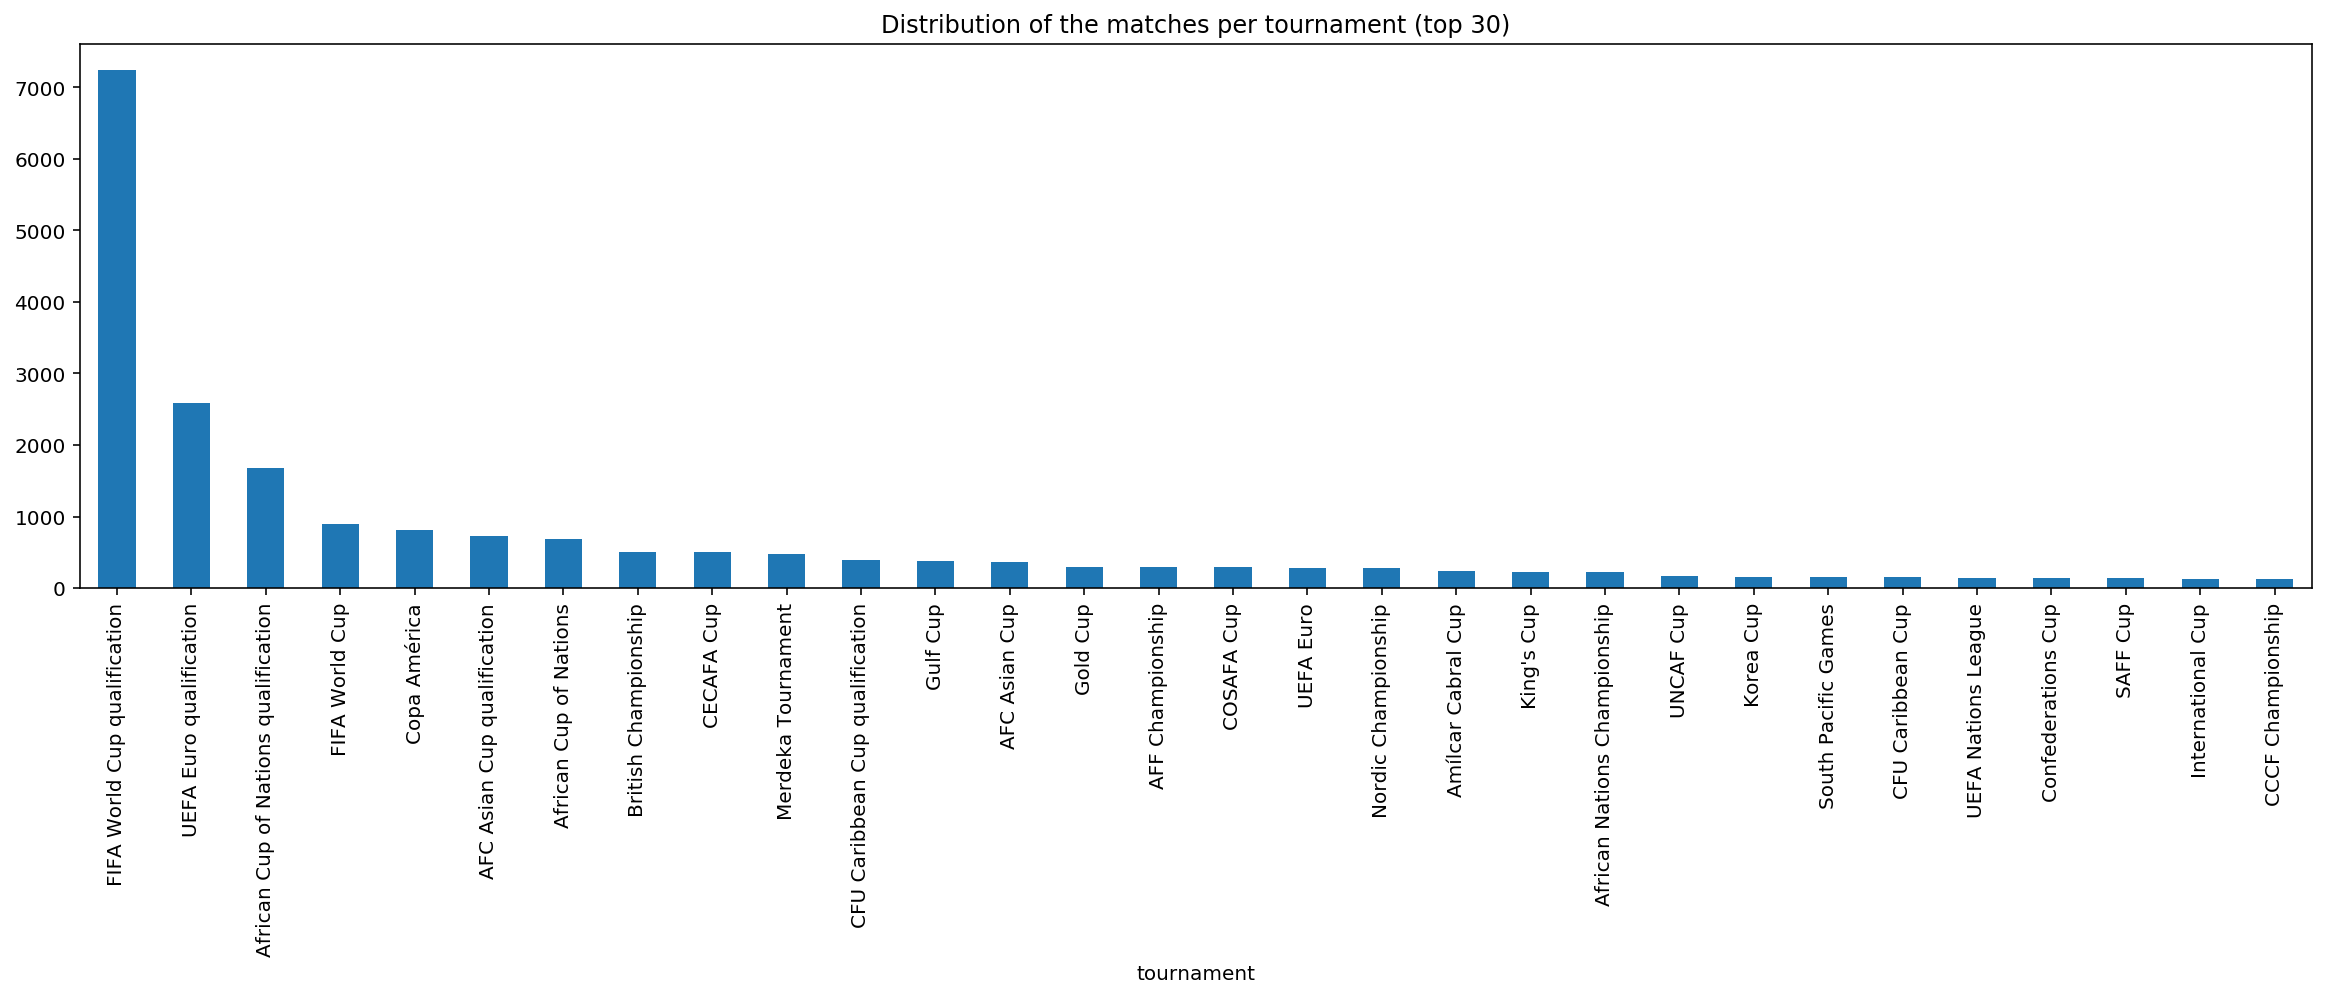

In [30]:
tournament_count=data['tournament'].groupby(data['tournament']).count().sort_values(0, ascending=False).drop('Friendly')
pd.DataFrame(tournament_count[:30]).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Distribution of the matches per tournament (top 30)')
plt.show()

Majority of competitive international matches are FIFA World Cup qualifications matches.

Here are all international competitions:

In [31]:
tournament_list = sorted(data['tournament'].unique())
a = [print('•', i, end=' ') for i in tournament_list]
print('\n\nNumber of competitions:', len(tournament_list))

• ABCS Tournament • AFC Asian Cup • AFC Asian Cup qualification • AFC Challenge Cup • AFC Challenge Cup qualification • AFF Championship • AFF Championship qualification • African Cup of Nations • African Cup of Nations qualification • African Nations Championship • African Nations Championship qualification • Amílcar Cabral Cup • Atlantic Cup • Balkan Cup • Baltic Cup • Brazil Independence Cup • British Championship • CCCF Championship • CECAFA Cup • CFU Caribbean Cup • CFU Caribbean Cup qualification • CONCACAF Championship • CONCACAF Championship qualification • CONCACAF Nations League • CONCACAF Nations League qualification • COSAFA Cup • Confederations Cup • Copa América • Copa América qualification • Copa Artigas • Copa Bernardo O'Higgins • Copa Carlos Dittborn • Copa Chevallier Boutell • Copa Félix Bogado • Copa Juan Pinto Durán • Copa Lipton • Copa Newton • Copa Oswaldo Cruz • Copa Paz del Chaco • Copa Premio Honor Argentino • Copa Premio Honor Uruguayo • Copa Ramón Castilla • 

Let's take a closer look at the biggest competition: the FIFA World Cup.

### FIFA World Cup stats

In [32]:
WC_data = data[data.tournament == 'FIFA World Cup']
WC_data.tail(2)

date home_team away_team  home_score  away_score      tournament  \
39948  2018-07-14   Belgium   England           2           0  FIFA World Cup   
39949  2018-07-15    France   Croatia           4           2  FIFA World Cup   

                 city country  neutral  
39948  St. Petersburg  Russia     True  
39949          Moscow  Russia     True

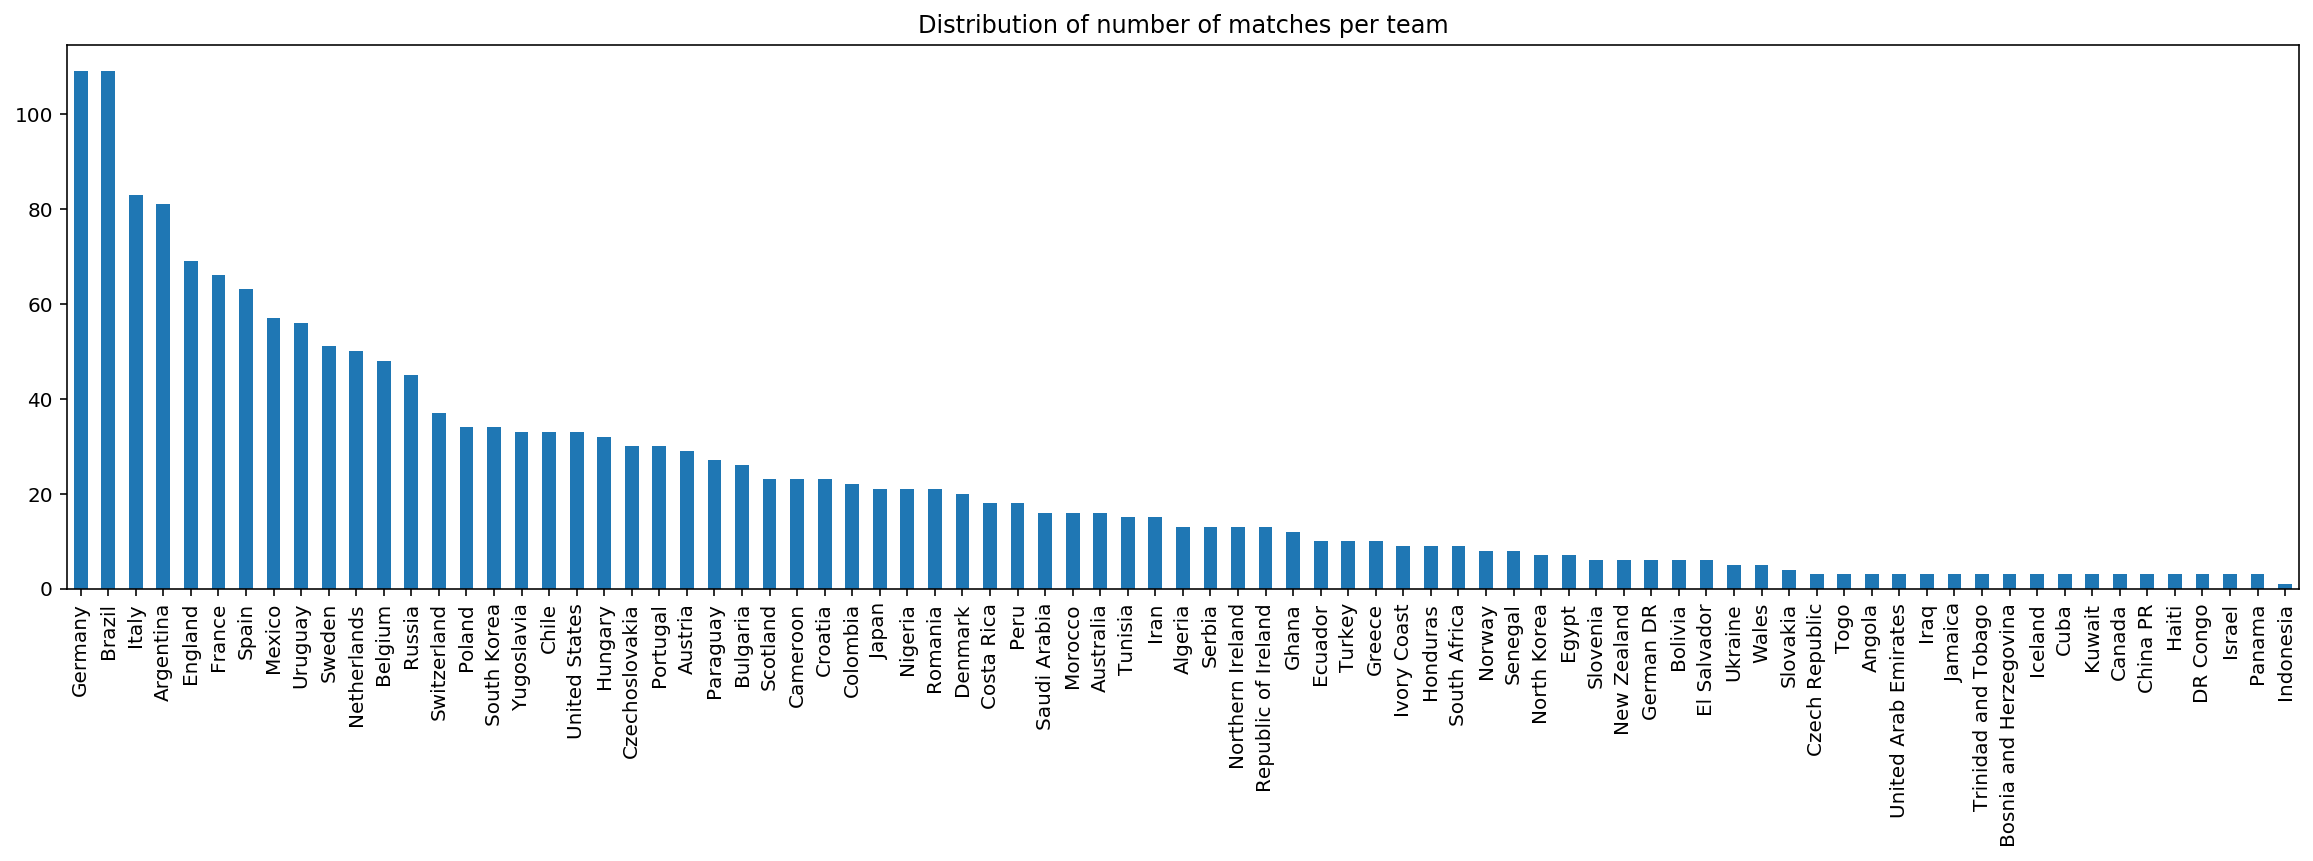

In [33]:
WC_match_participants=pd.concat([WC_data['home_team'],WC_data['away_team']])
WC_match_participants_count=WC_match_participants.groupby(WC_match_participants).count().sort_values(0, ascending=False)
pd.DataFrame(WC_match_participants_count).plot.bar(y=0,legend=False, figsize=(20,5),
                                                title='Distribution of number of matches per team')
plt.show()

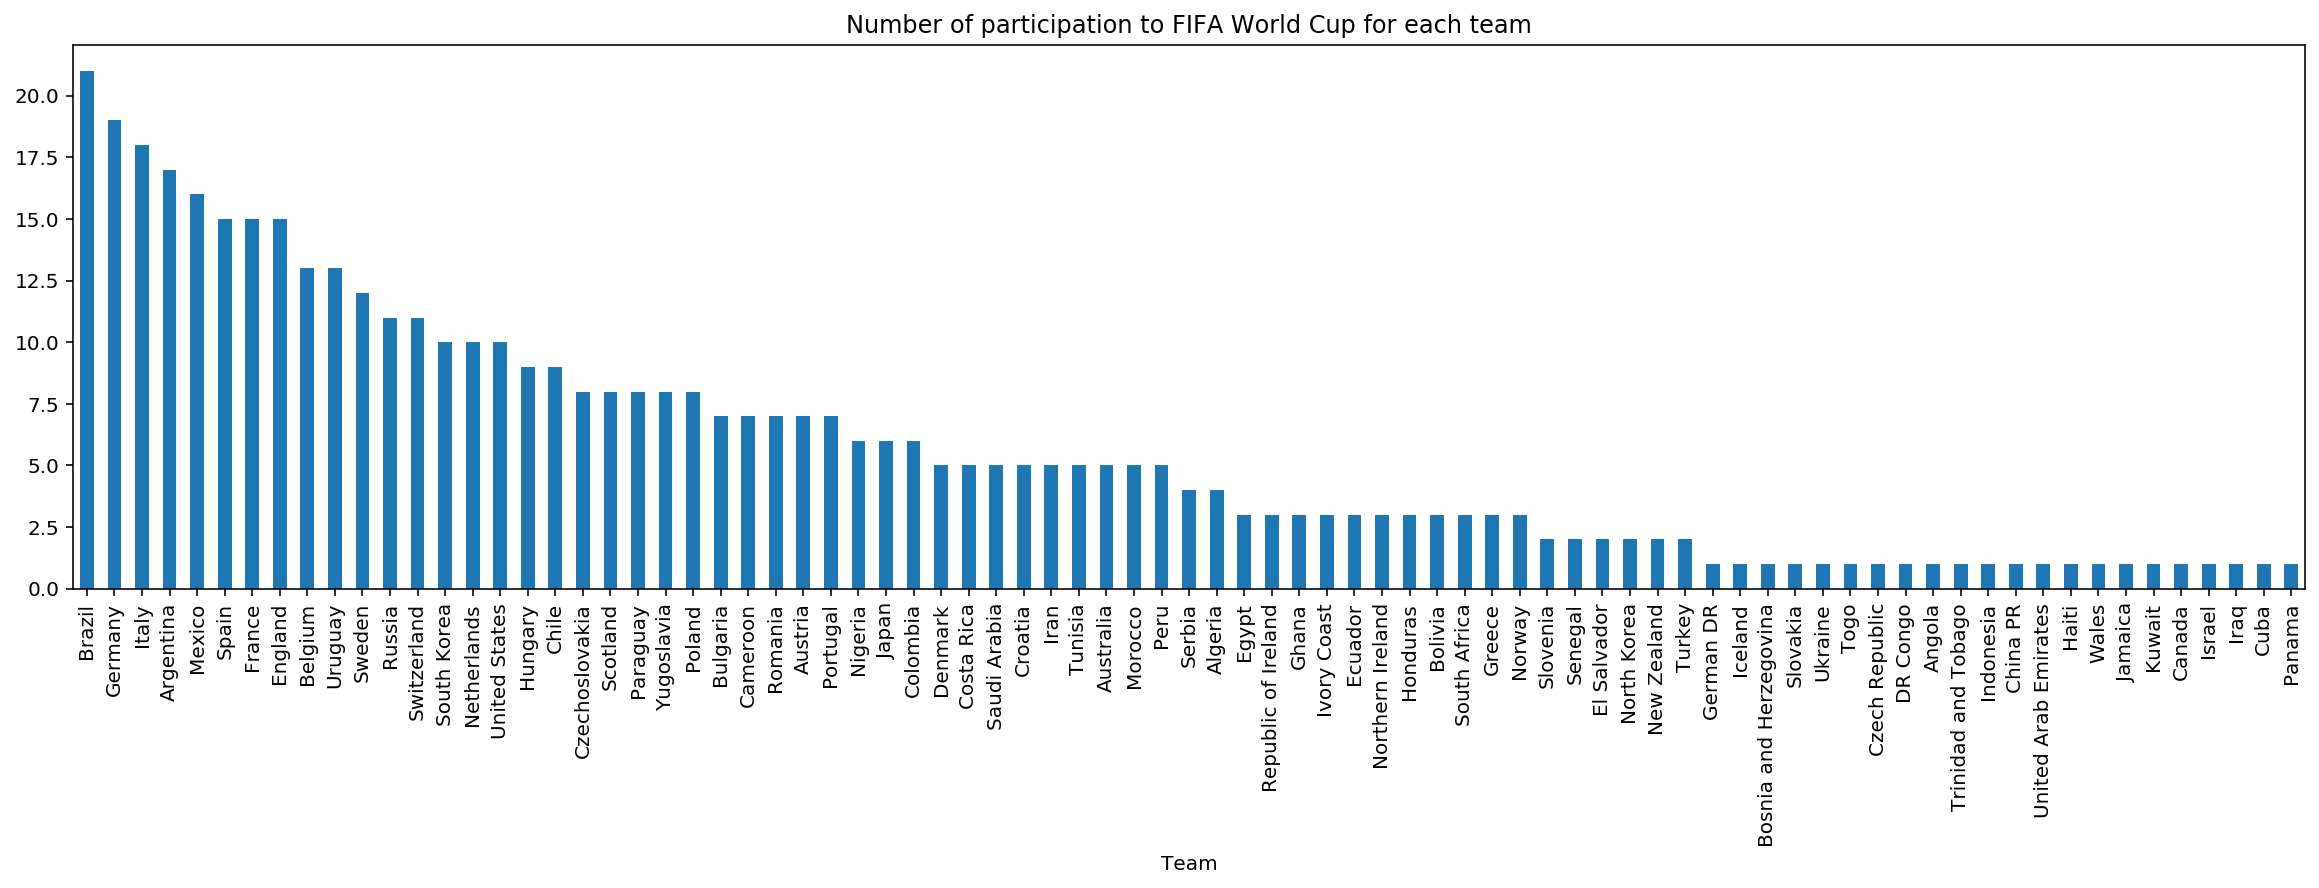

In [34]:
def append(dic, team):
    if team not in dic:
        dic[team] = []
        dic[team].append(1)
        dic[team].append(row.date[:4])
    if row.date[:4] not in dic[team]:
        dic[team][0] += 1
        dic[team].append(row.date[:4])
    return dic

dic = {}
date = []
for i in range(len(WC_data)):
    row = WC_data.iloc[i]
    team = row.home_team
    dic = append(dic, team)
    team = row.away_team
    dic = append(dic, team)
for e in dic:
    dic[e] = dic[e][0]
    
WC_participation = pd.DataFrame(dic.items())
WC_participation.columns = ['Team', 'Participations']
WC_participation = WC_participation.set_index(['Team'])
WC_participation=WC_participation.sort_values(by=['Participations'], ascending=False)
pd.DataFrame(WC_participation).plot.bar(y=0,legend=False, figsize=(20,5),
                                                title='Number of participation to FIFA World Cup for each team')
plt.show()

Brazil, Germany and Italy are the countries that have participated the most in World Cups. This might be why they are at the top of the list of countries that have played the most games in the World Cup.

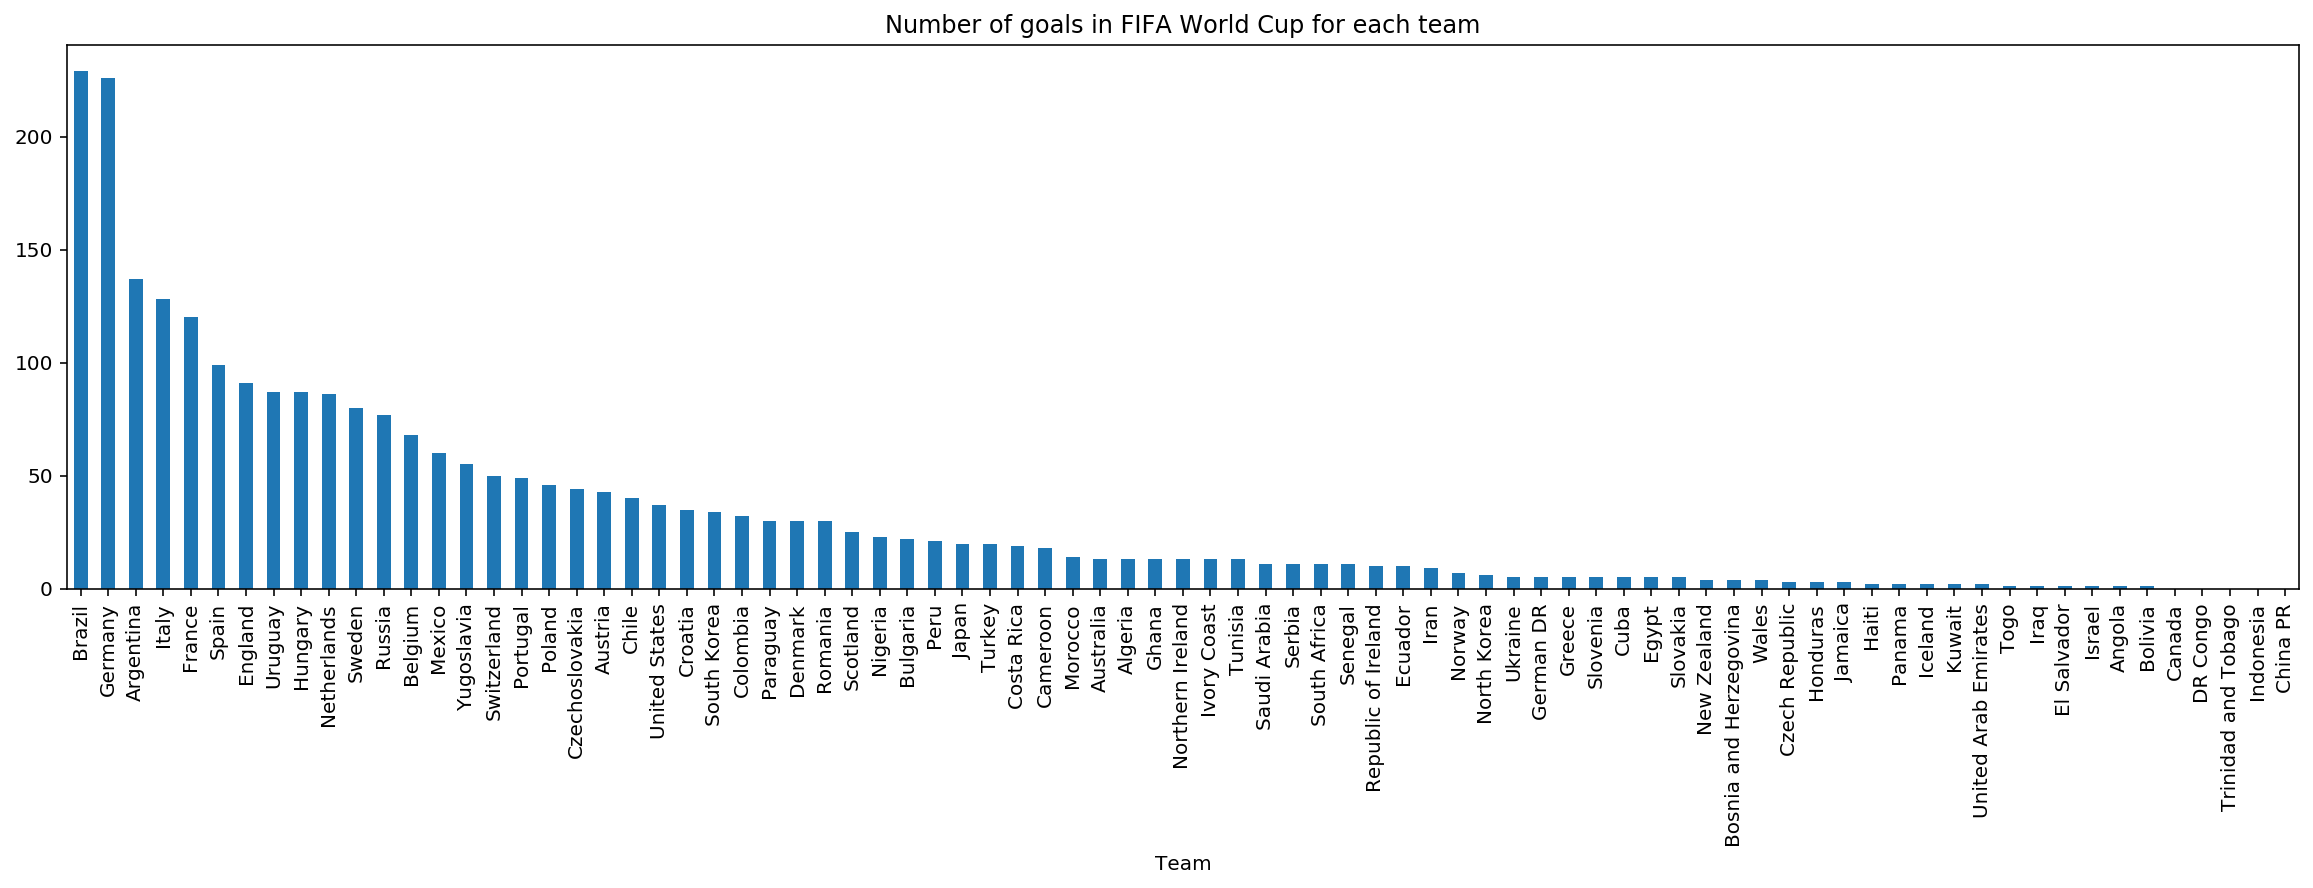

In [35]:
nb_goals = [(WC_data[WC_data['home_team']==team]).home_score.sum()+(WC_data[WC_data['away_team']==team]).away_score.sum() for team in list(WC_match_participants.unique())] 
    
WC_goals = {'Team': list(WC_match_participants.unique()), 'Goals': nb_goals}
WC_goals = pd.DataFrame.from_dict(WC_goals, orient='index').T.set_index(['Team'])
WC_goals=WC_goals.sort_values(by=['Goals'], ascending=False)
pd.DataFrame(WC_goals).plot.bar(y=0,legend=False, figsize=(20,5),
                                               title='Number of goals in FIFA World Cup for each team')
plt.show()

A high number of participation does, however, not necessarily imply a high number of goals, Mexico is a good example.

C:\Users\ajlre\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



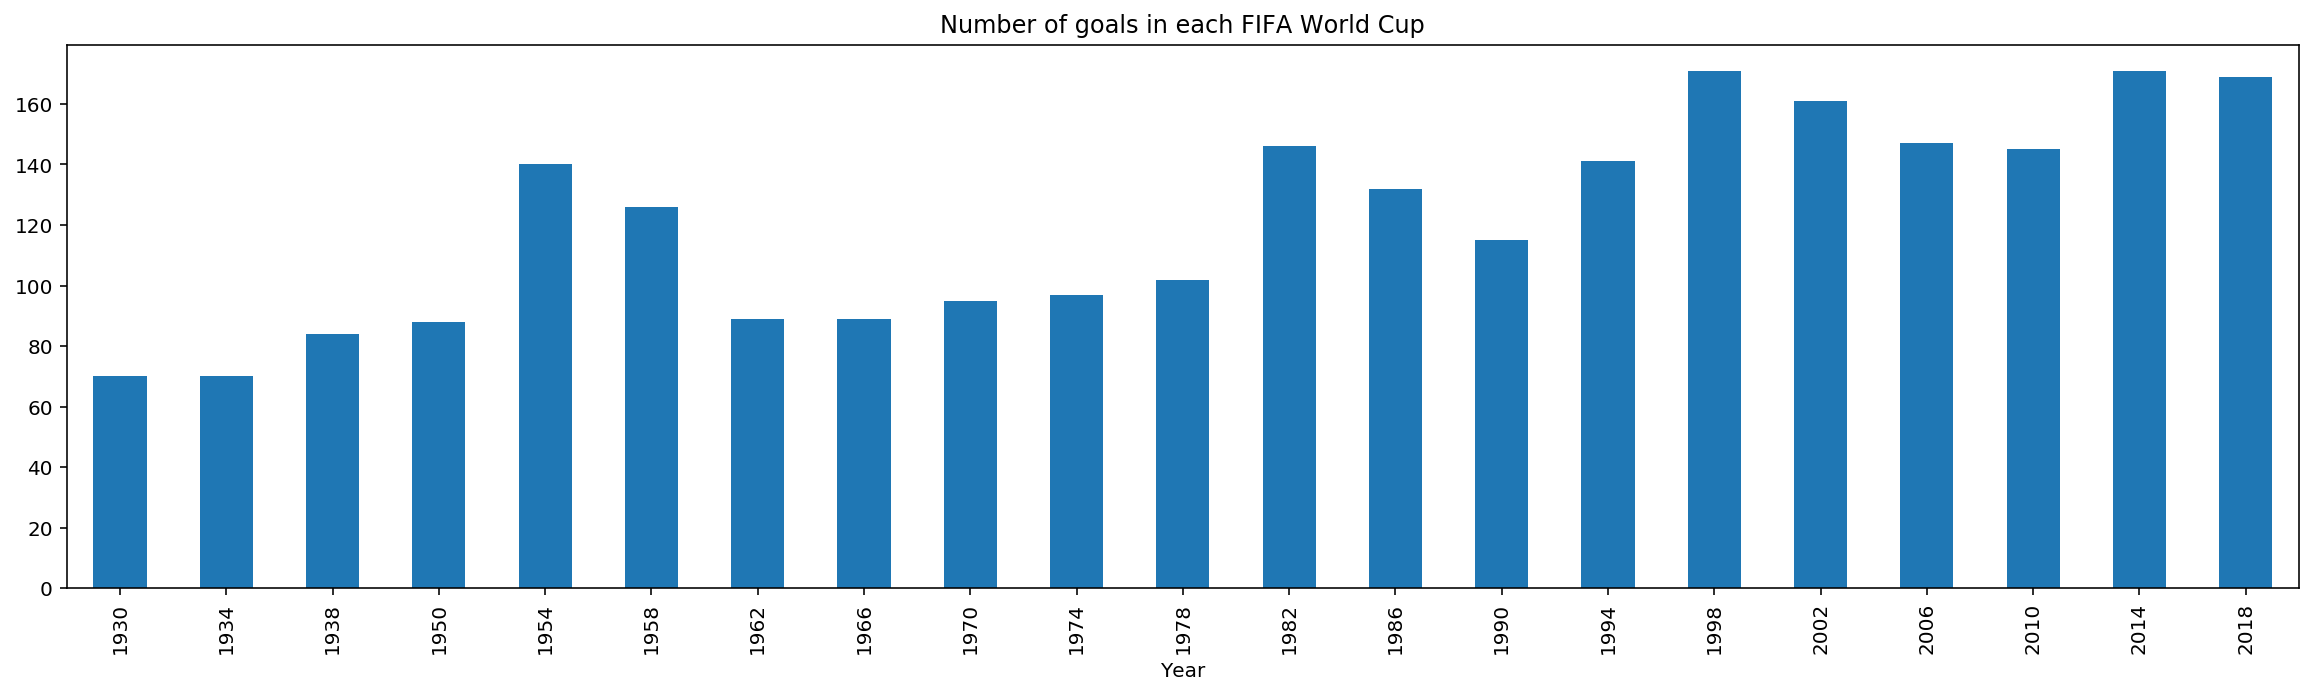

In [36]:
dates = sorted(list(set([d[:4] for d in list(WC_data['date'])])))
WC_data['date'] = WC_data['date'].apply(lambda x: x[:4])
total = []
for d in dates:
    total.append( (WC_data[WC_data.date==d]).home_score.sum()+ (WC_data[WC_data.date==d]).away_score.sum())
WC_goals = {'Year': dates, 'Goals': total}
WC_goals = pd.DataFrame.from_dict(WC_goals, orient='index').T.set_index(['Year'])
pd.DataFrame(WC_goals).plot.bar(y=0,legend=False, figsize=(20,5),
                                               title='Number of goals in each FIFA World Cup')
plt.show()

In [37]:
teams = [len(set(WC_data[WC_data.date==d].away_team).union(set(WC_data[WC_data.date==d].home_team))) for d in dates]
participant = {'Year': dates, 'Participants': teams}
participant = pd.DataFrame.from_dict(participant, orient='index').T.set_index(['Year'])
display(participant.T)

Year         1930 1934 1938 1950 1954 1958 1962 1966 1970 1974 1978 1982 1986  \
Participants   13   16   15   13   16   16   16   16   16   16   16   24   24   

Year         1990 1994 1998 2002 2006 2010 2014 2018  
Participants   24   24   32   32   32   32   32   32

More goals have been scored on the world cup in recent years, but this is probably due to a greater number of teams.

___
## Match location
### Distribution of match locations per country (top and low 50)


In [38]:
country_count = pd.DataFrame(data['country'].value_counts())
nb = country_count.loc["England"]  + country_count.loc["Scotland"] + country_count.loc["Wales"]
country_count.loc['United Kingdom'] = [nb.values.item()]

data3 = dict(type = 'choropleth', colorscale = 'Reds', locations = country_count.index,
            locationmode = 'country names', z = country_count['country'], text = country_count.index,
            colorbar = {'title':'Nb of hosted matches'})

layout3 = dict(title = 'Number of matches hosted by country',
               geo = dict(showframe = False, projection = {'type':'natural earth'}))

choromap3 = go.Figure([data3],layout3)
pyo.iplot(choromap3)

The United States are hosting a lot of matches even though they are not even in the top ten of the teams that have played the most.We anticipate most of them to be neutral game hostings. Let's visualize this:

In [39]:
us_matches = data[data['country']=='United States']

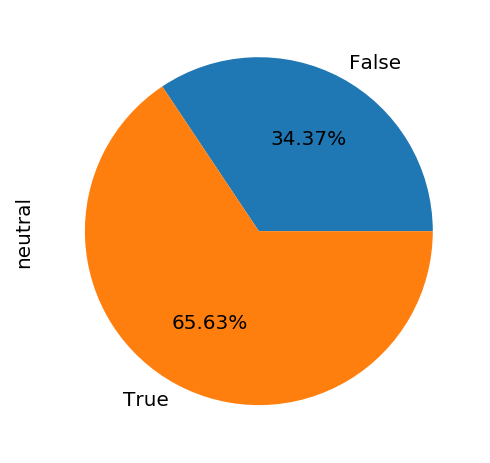

In [40]:
pd.DataFrame(us_matches['neutral']).groupby(us_matches['neutral']).count().plot.pie(y=0, autopct='%1.2f%%', startangle=0, legend=False)
plt.show()

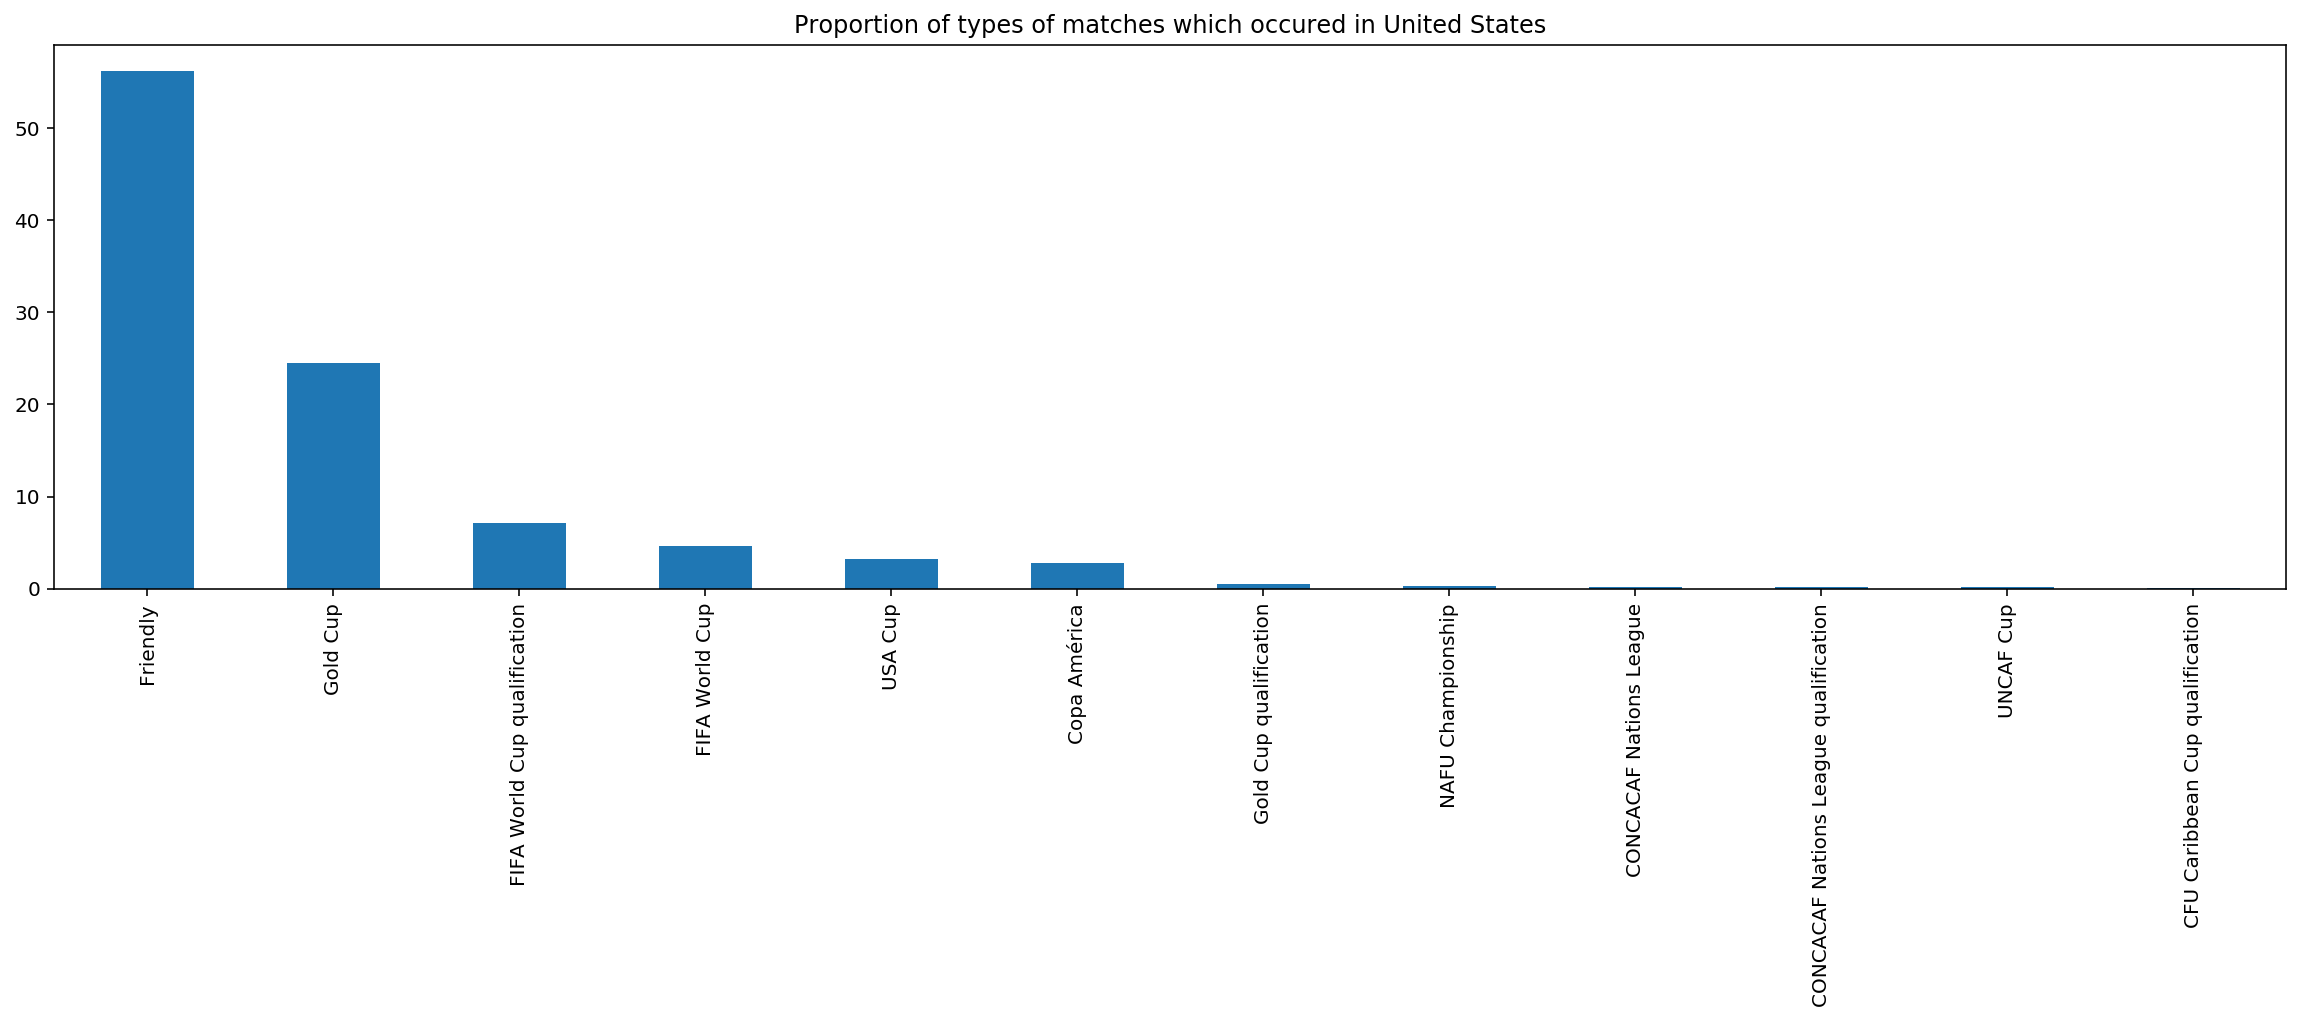

In [41]:
(us_matches['tournament'].value_counts()/us_matches['tournament'].count()*100).plot.bar(y=0, legend=False, figsize=(20, 5),
                                                                    title='Proportion of types of matches which occured in United States')
plt.show()

Indeed, the majority of matches played in the US are neutral. That being said, a considerable amount of matches have been played during the Gold Cup (North American championship).

### Distribution of the matches per city (top and low 50)


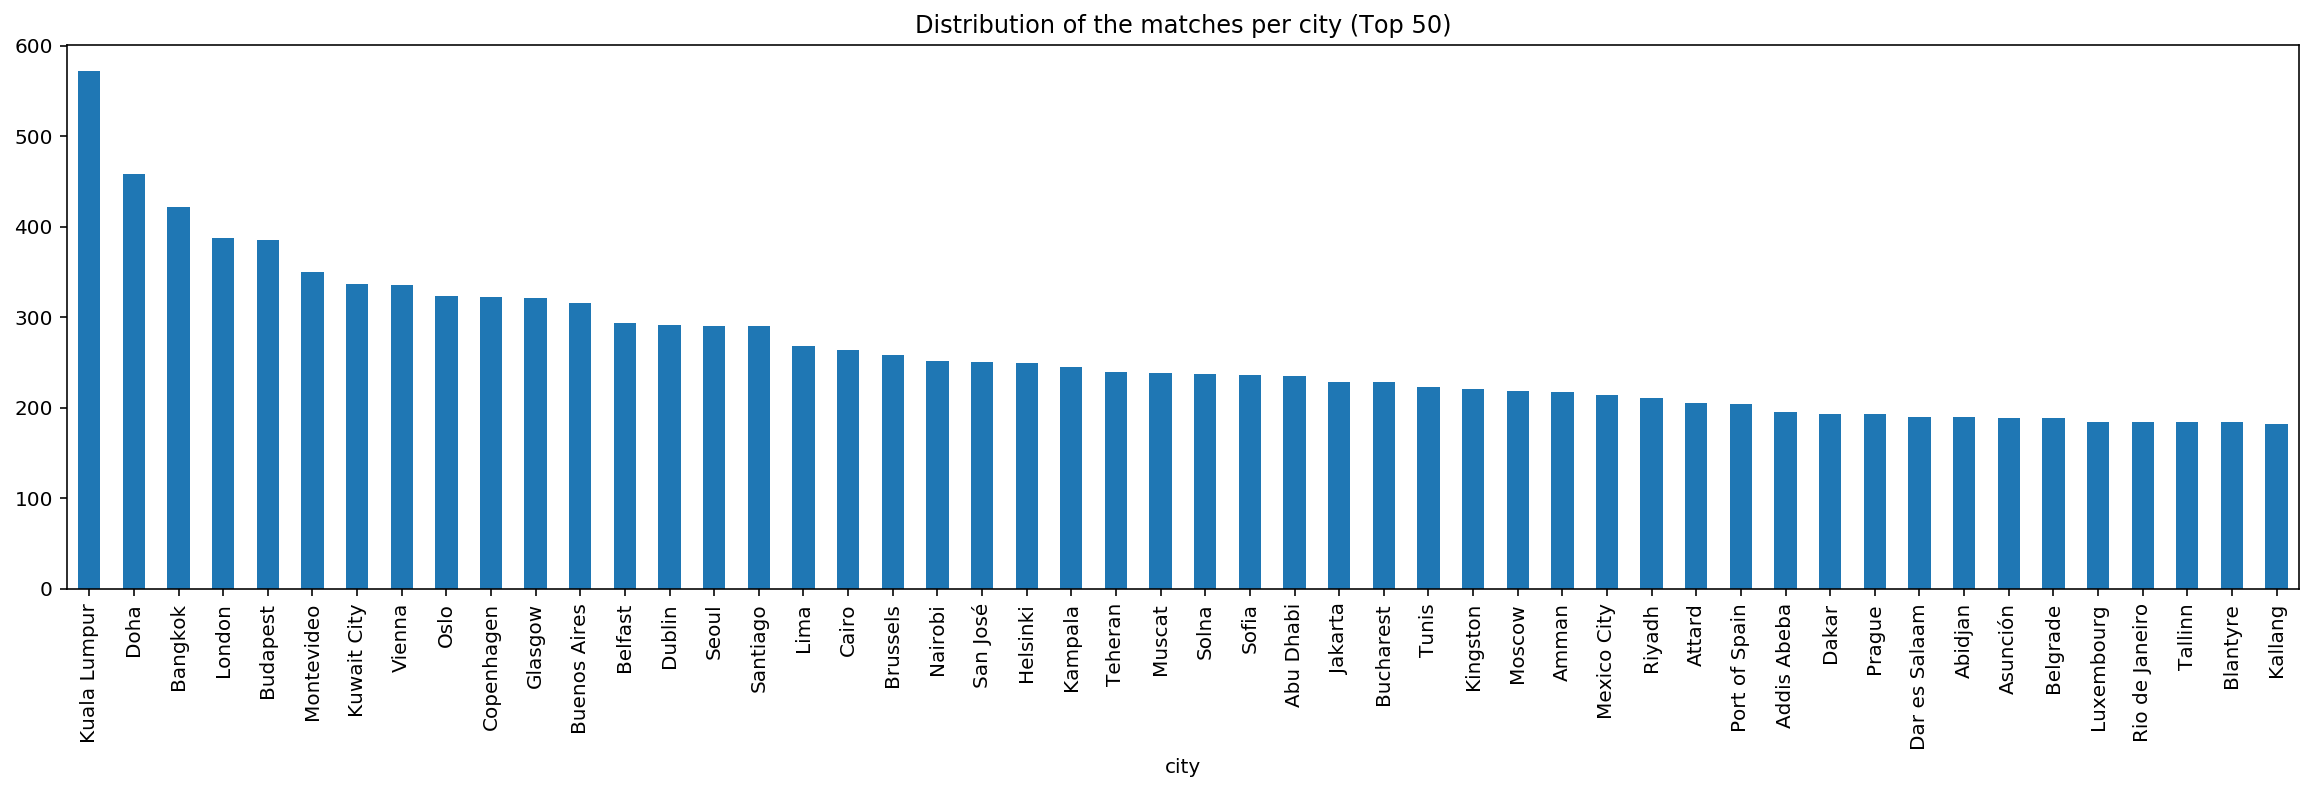

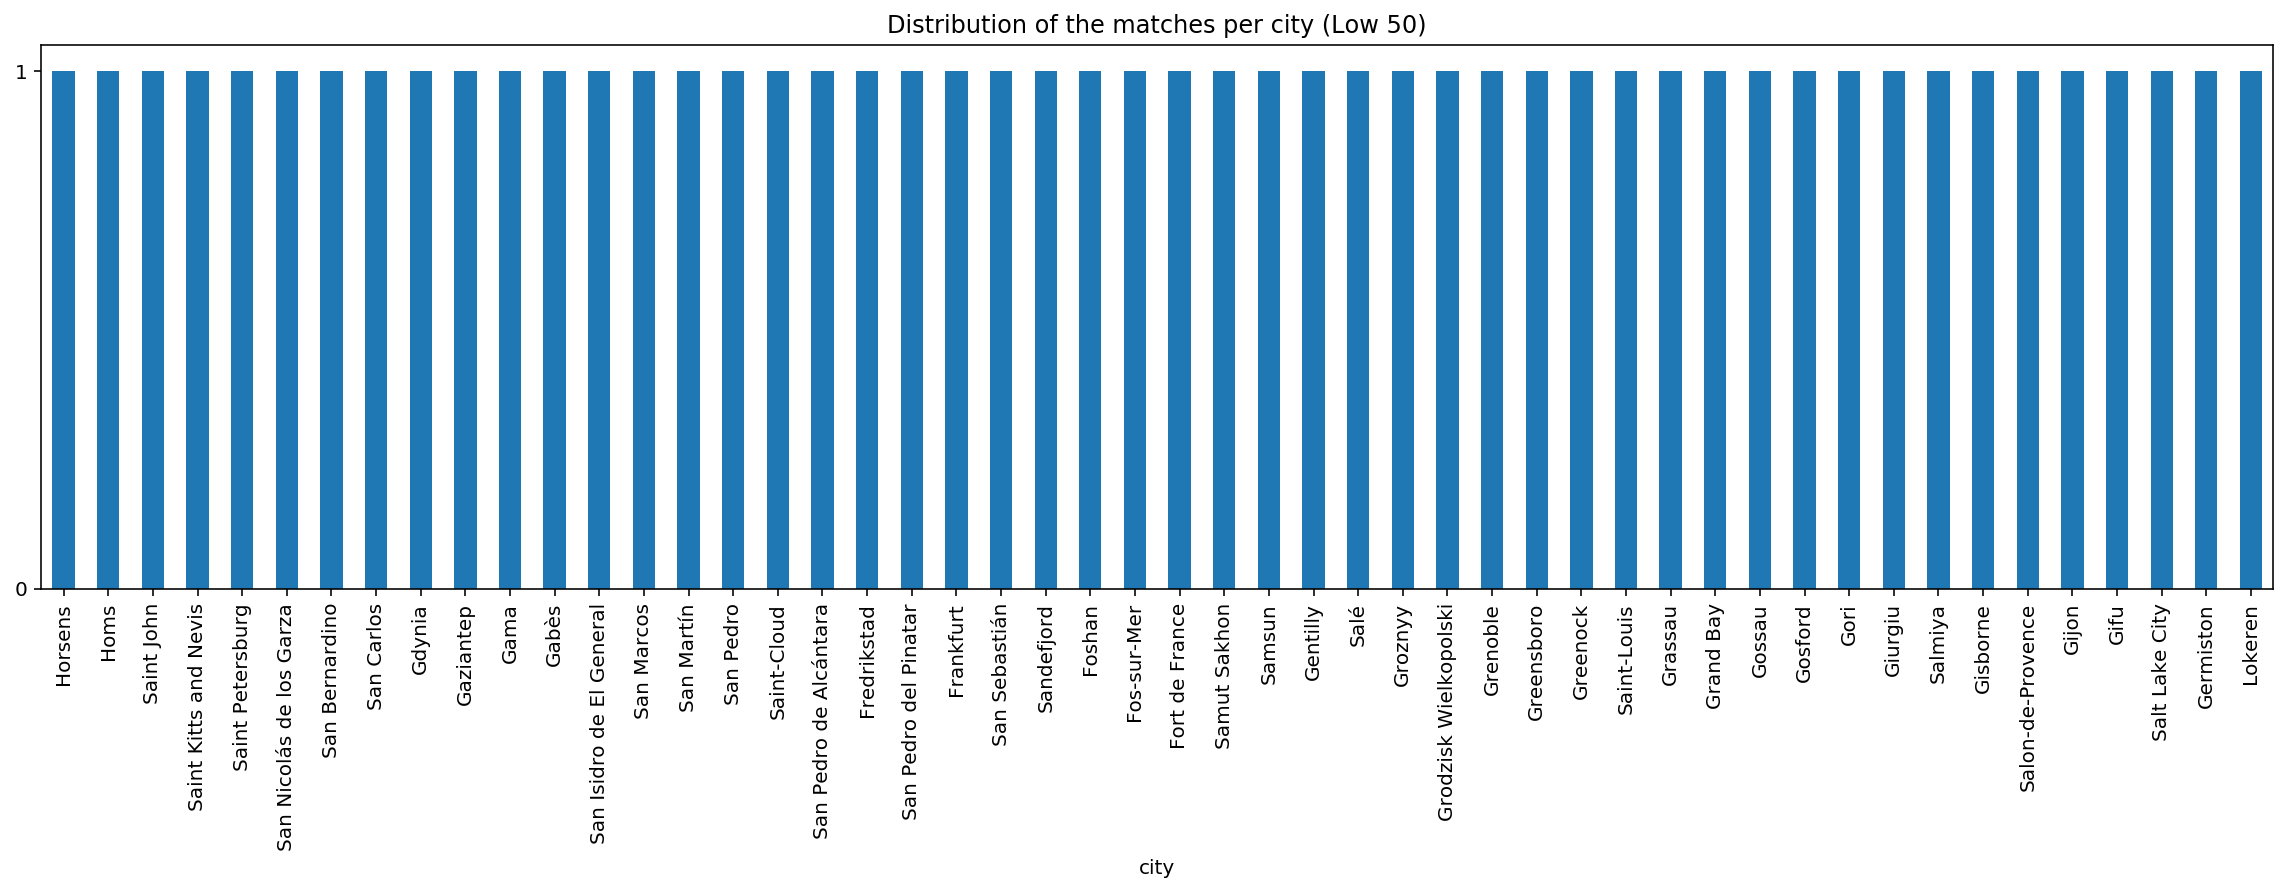

In [42]:
city_count=data['city'].groupby(data['city']).count().sort_values(0, ascending=False)
pd.DataFrame(city_count[:50]).plot.bar(y=0,legend=False, figsize=(20,5), title='Distribution of the matches per city (Top 50)')
pd.DataFrame(city_count[-50:]).plot.bar(y=0,legend=False, figsize=(20,5), title='Distribution of the matches per city (Low 50)')
plt.yticks([0,1])
plt.show()

## Neutral, away and home matches

### Repartition of neutral vs non-neutral fields


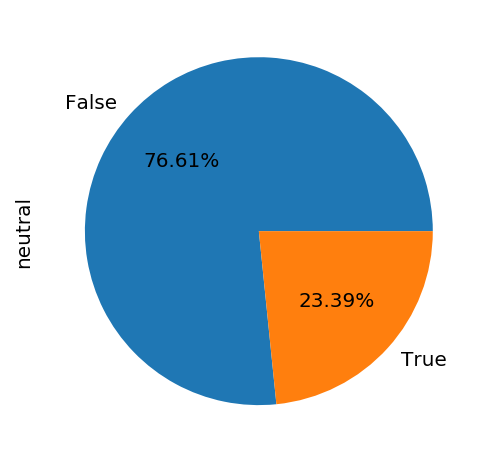

In [43]:
city_count=data['neutral'].groupby(data['neutral']).count()
pd.DataFrame(city_count[:10]).plot.pie(y=0,legend=False, autopct='%1.2f%%', startangle=0)
plt.show()

### Comparative stats on the scores for neutral vs non-neutral fields


In [44]:
neutral_matches=data[data['neutral']==True]
non_neutral_matches=data[data['neutral']==False]
neutral_diff=np.abs(neutral_matches['home_score']-neutral_matches['away_score'])
non_neutral_diff=np.abs(non_neutral_matches['home_score']-non_neutral_matches['away_score'])
non_neutral_advantage=non_neutral_matches['home_score']-non_neutral_matches['away_score']

print('For Neutral Fields:')
print('Mean difference in score -  -  :', round(np.mean(neutral_diff), 3))
print('Median difference in score  -  :',round(np.median(neutral_diff), 3))
print('Std of the difference in score :',round(np.std(neutral_diff), 3))

print('\nFor Non-Neutral Fields:')
print('Mean difference in score -  -  -  -  -  -  - :',round(np.mean(non_neutral_diff), 3))
print('Median difference in score  -  -  -  -  -  - :',round(np.median(non_neutral_diff), 3))
print('Std of the difference in score -  -  -  -  - :',round(np.std(non_neutral_diff), 3))
print('Mean advantage in score for home teams  -  - :',round(np.mean(non_neutral_advantage), 3))
print('Median advantage in score for home teams   - :',round(np.median(non_neutral_advantage), 3))
print('Std of the advantage in score for home teams :',round(np.std(non_neutral_advantage), 3))

For Neutral Fields:
Mean difference in score -  -  : 1.685
Median difference in score  -  : 1.0
Std of the difference in score : 1.842

For Non-Neutral Fields:
Mean difference in score -  -  -  -  -  -  - : 1.658
Median difference in score  -  -  -  -  -  - : 1.0
Std of the difference in score -  -  -  -  - : 1.661
Mean advantage in score for home teams  -  - : 0.651
Median advantage in score for home teams   - : 1.0
Std of the advantage in score for home teams : 2.255


### Repartition of home vs away team victories for non-neutral fields


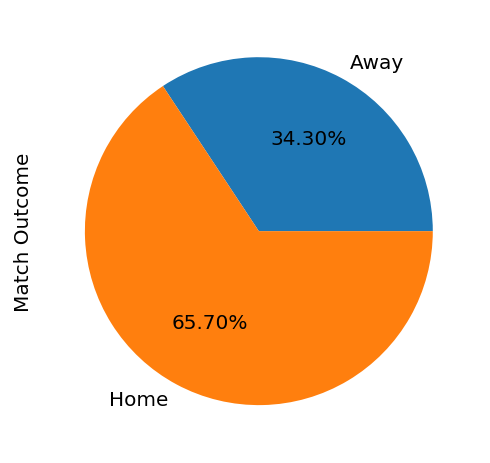

In [45]:
non_neutral_victories=non_neutral_advantage[non_neutral_advantage!=0]
non_neutral_victories[non_neutral_advantage>0]='Home'
non_neutral_victories[non_neutral_advantage<0]='Away'
non_neutral_victories=non_neutral_victories.groupby(non_neutral_victories).count()
pd.DataFrame(non_neutral_victories).rename(columns={0:'Match Outcome'}).plot.pie(y=0, legend=False, autopct='%1.2f%%', startangle=0)
plt.show()

### Compararative stats on the scores of home vs away teams for non-neutral fields

In [46]:
print('For Home Teams:')
print('Mean score       :', round(np.mean(non_neutral_matches['home_score']), 3))
print('Median score     :', round(np.median(non_neutral_matches['home_score']), 3))
print('Std of the score :', round(np.std(non_neutral_matches['home_score']), 3))

print('\nFor Away Teams:')
print('Mean score       :', round(np.mean(non_neutral_matches['away_score']), 3))
print('Median score     :', round(np.median(non_neutral_matches['away_score']), 3))
print('Std of the score :', round(np.std(non_neutral_matches['away_score']), 3))

For Home Teams:
Mean score       : 1.764
Median score     : 1.0
Std of the score : 1.703

For Away Teams:
Mean score       : 1.113
Median score     : 1.0
Std of the score : 1.283


- Most matches take place on a non-neutral field.
- Matches on non-neutral fields are mostly won by the home team.
- The average score of for home teams is considerably higher than the one of away teams.
- Matches on a neutral field have more varied results and higher mean score difference.

### Repartition of goals between home and away team depending on the type of match

In [47]:
home_score_list = list(data.groupby(data['tournament']).home_score.sum())
away_score_list = list(data.groupby(data['tournament']).away_score.sum())

In [48]:
t1={'x':tournament_list,'y':home_score_list,'name':'Home Score','type':'bar', 'marker':dict(color = 'orange')};
t2={'x':tournament_list,'y':away_score_list,'name':'Away Score','type':'bar', 'marker':dict(color = 'rgb(58, 119, 155)')};
data1=[t1,t2]
layout = {'xaxis': {'title': 'Tournaments'},
          'barmode': 'relative',
          'title': 'Repartition of goals between home and away team depending on the type of match'};
fig = go.Figure(data = data1, layout = layout)
pyo.iplot(fig)

# Dataset Limitations

The only limition that came to light through this analysis is the following:

In [49]:
#Getting the list of teams which don't exist anymore
teams_2019=data[data['date'].str.startswith('2019')]
teams_2019=pd.concat([teams_2019['home_team'],teams_2019['away_team']]).unique()
teams=pd.concat([data['home_team'],data['away_team']]).unique()
set(teams)-set(teams_2019)

{'Burma',
 'Cook Islands',
 'Czechoslovakia',
 'East Timor',
 'German DR',
 'Saarland',
 'Vietnam Republic',
 'Yemen DPR',
 'Yugoslavia'}

Some teams have disolved or lost legitimacy over time and will need to be taken care of.